# Meta-Analyze Results from Multiple Studies
J. Nathan Matias, June 2022

This file meta-analyzes results from multiple studies. The [pre-analysis plan for these studies](https://osf.io/ymv9h/) is on the open science framework.

* `reddit-ffxiv-analysis-2020.ipynb`
* `reddit-science-analysis-2022.ipynb`
* `/Users/nathan/Dropbox (MIT)/Apps/ShareLaTeX/PNAS r_science experimentarchive/community-experiments.Rtex`
  * *exs.posts*: posts in the experiment
  * *pre.posts*: posts from before the experiment
  
  
**TODO**:
* Decide if we also want pre/post data for r/ffxiv

In [231]:
ffxiv.data.dir = "~/Tresors/CivilServant/projects/CivilServant-reddit/r-ffxiv-2020"
ffxiv.newcomer.comments.filename = "r-ffxiv-newcomer-comments-11.22.2020.csv"
ffxiv.all.comments.filename = "r-ffxiv-all-comments-11.22.2020.csv"
ffxiv.posts.filename = "r-ffxiv-posts-11.22.2020.csv"


r.science.2020.data.dir = "~/Tresors/CivilServant/projects/CivilServant-reddit/2020-r-science"
r.science.2020.all.comments.filename = "r-science-all-comments-07.07.2022.csv"
r.science.2020.newcomer.comments.filename = "r-science-newcomer-comments-07.07.2022.csv"
r.science.2020.posts.filename = "r-science-posts-06.19.2022.csv"
r.science.2020.before.after.posts.filename = "r-science-before-after-posts-06.10.2022.csv"

r.science.2017.data.dir <- "/Users/nathan/Dropbox (MIT)/Apps/ShareLaTeX/PNAS r_science experiment/"
r.science.2017.data.file <- "r_science_experiment_results_08.25.2016_09.23.2016_02.01.2019.RData"

r.science.2017.experiment.posts.data.dir <- "~/Tresors/CivilServant/projects/CivilServant-reddit/r-science-2016"
r.science.2017.experiment.posts.data.file <- "r_science_experiment_1_posts.09.26.2016.csv"

load(file.path(r.science.2017.data.dir, r.science.2017.data.file))




In [232]:
library(gmodels)  # Contains CrossTable
library(estimatr) # Contains difference_in_means
library(MASS)     # Contains glm.nb
library(rms)      # Contains lrm
library(lme4)     # Contains glmer
library(lmerTest) # Includes significance testing for glmer
library(ri2)      # Randomization inference libraries
library(texreg)   # Generate tables
library(estimatr) # provides lm_robust
library(sysfonts) # to load source sans pro
library(grid)
library(gridExtra)
library(png)      # to load images
library(ggpubr)   # includes annotate_figure
library(plm)      # fixed effects models


cat.logo.filename <- "./CAT-Logo-Horizontal-social-media-preview-color.png"
logo.img <- readPNG(cat.logo.filename)
logo.pngob <- rasterGrob(logo.img)

## Set visual style
catpalette   <- c("#333333", "#ea5324", "#005073", "#7D868C", "#BDBBBB", "#F2F2F2","#F6F2EB")
chartpalette <- c("#ea5324", "#005073", "#7D868C", "#333333", "#F2F2F2","#BDBBBB", "#F6F2EB")
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

bg.whiteortransparent <- Sys.getenv('RTRANSPARENTBG','white')


cat.theme <-  theme_bw() +
              theme(plot.title = element_text(size=13, face="bold", color=catpalette[3]),
                    axis.title.x =element_text(size=10, hjust = -0.01, color = catpalette[1]),
                    axis.title.y =element_text(size=10, color = catpalette[1]),
                    panel.background = element_rect(fill=catpalette[6]),
                    plot.background = element_rect(fill =bg.whiteortransparent, color = NA), # bg of the plot
#                    text=element_text(size=16,  family="Source Sans Pro")                    
                   )

end.caption.text = "

Citizens & Technology Lab - citizensandtech.org
© Creative Commons International Attribution 4.0"


#critical value for 3 comparisons is 2.398
critval.3 <- 2.398
critval = 1.96

# Set up and Load Variables

In [233]:
## pre and post experiment variables
before.posts.science.2017.df <- pre.posts

before.after.posts.science.2020.df <- read.csv(file.path(r.science.2020.data.dir, 
                                                         r.science.2020.before.after.posts.filename))

before.after.posts.science.2020.df$before_during_after <- relevel(before.after.posts.science.2020.df$before_during_after, ref="during")


In [234]:
## experiment posts

## note: omit AMA posts from the 2017 dataset
exp.posts.science.2017.df <- subset(read.csv(file.path(r.science.2017.experiment.posts.data.dir,
                                                r.science.2017.experiment.posts.data.file)), AMA=="False")

exp.posts.science.2020.df <- read.csv(file.path(r.science.2020.data.dir, 
                                                         r.science.2020.posts.filename))

exp.posts.science.2020.df$created.date <- as.Date(exp.posts.science.2020.df$created)

exp.posts.ffxiv.df        <- read.csv(file.path(ffxiv.data.dir, 
                                                         ffxiv.posts.filename))

In [235]:
## make block IDs into numbers
exp.posts.science.2017.df$block.id.int <- as.numeric(gsub("nonama.block", "", exp.posts.science.2017.df$block.id))
exp.posts.science.2020.df$block.id.int <- as.numeric(gsub("block", "", exp.posts.science.2020.df$block.id))
exp.posts.ffxiv.df$block.id.int        <- as.numeric(gsub("block", "", exp.posts.ffxiv.df$block.id))

outlier.block.ids <- subset(exp.posts.science.2020.df, num.comments > 8000)$block.id

In [236]:
## experiment newcomer comments
exp.newcomer.comments.science.2020.df <- read.csv(file.path(r.science.2020.data.dir, r.science.2020.newcomer.comments.filename))
exp.newcomer.comments.science.2020.df$visible.int <- as.numeric(exp.newcomer.comments.science.2020.df$visible) - 1
exp.newcomer.comments.science.2017.df <- subset(newcomer.comments, post.ama==FALSE)

exp.newcomer.comments.ffxiv.df <- read.csv(file.path(ffxiv.data.dir, ffxiv.newcomer.comments.filename))

In [237]:
exp.posts.science.2020.df$day.num <- as.numeric(exp.posts.science.2020.df$created.date - min(exp.posts.science.2020.df$created.date))

# Summary Statistics for Communities

In [238]:
posts.per.day <- function(df){
    num.days <- as.integer(max(as.Date(df$created)) - min(as.Date(df$created)))
    posts.per.day <- nrow(df) / num.days
    return(posts.per.day)
}

comments.per.post <- function(df){
    df <- subset(df, treatment==0)
    sum(df$num.comments) / nrow(df)     
}

newcomer.comments.per.post <- function(df){
    df <- subset(df, treatment==0)
    sum(df$newcomer.comments) / nrow(df)     
}


newcomer.comments.removed.per.post <- function(df){
    df <- subset(df, treatment==0)
    sum(df$newcomer.comments.removed) / nrow(df)     
}


In [239]:
#comments.per.post(subset(exp.posts.science.2020.df, (block.id.int %in% outlier.block.ids)!=TRUE))

In [240]:
#newcomer.comments.removed.per.post(exp.posts.ffxiv.df)

In [241]:
min(exp.posts.science.2020.df$created.date)

[1] "2020-02-24"

# Summarize Base Moderation Rates Before the Experiment and Set up Dataframes

In [242]:
## Num Comments
summary(before.posts.science.2017.df$num.comments)
summary(subset(before.after.posts.science.2020.df, before_during_after=="before")$num.comments)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    1.00   21.19    2.00 4267.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    4.00   81.49   15.00 6667.00 

In [243]:
## Num Comments Removed
summary(before.posts.science.2017.df$num.comments.removed)
summary(subset(before.after.posts.science.2020.df, before_during_after=="before")$num.comments.removed)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    8.553    0.000 2549.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    1.00   27.76    3.00 3314.00 

In [244]:
## Num Comments
summary(before.posts.science.2017.df$num.commenters)
summary(subset(before.after.posts.science.2020.df, before_during_after=="before")$num.commenters)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    1.00   13.98    2.00 2682.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    3.00   54.35   12.00 4069.00 

In [245]:
colnames(before.after.posts.science.2020.df)

[1] "before_during_after"  "created"              "num.commenters"      
 [4] "num.comments"         "num.comments.removed" "study_post"          
 [7] "treatment"            "visible"              "weekday"             
[10] "weekend"

In [246]:
before.posts.science.2017.df <- before.posts.science.2017.df[c('num.comments', 'num.comments.removed','num.commenters', "weekend", "visible")]
before.posts.science.2017.df$before_during_after = "before"
before.posts.science.2017.df$treatment = NA
before.posts.science.2017.df$study_post = FALSE

during.posts.science.2017.df <- exp.posts.science.2017.df[c('num.comments', 'num.comments.removed','num.commenters', "weekend", "visible", "treatment")]
during.posts.science.2017.df$before_during_after = "during"
during.posts.science.2017.df$study_post = TRUE

before.during.posts.science.2017.df <- rbind(before.posts.science.2017.df, during.posts.science.2017.df)
before.during.posts.science.2017.df$before_during_after <- factor(before.during.posts.science.2017.df$before_during_after)
before.during.posts.science.2017.df$before_during_after <- relevel(before.during.posts.science.2017.df$before_during_after, ref="during")

## Compare rates before and after to rates in the control group

#### Set up dependent variables

In [247]:
before.during.posts.science.2017.df$prop.comments.removed <- before.during.posts.science.2017.df$num.comments.removed / 
                                                             (before.during.posts.science.2017.df$num.comments + 1)

before.after.posts.science.2020.df$prop.comments.removed <- before.after.posts.science.2020.df$num.comments.removed / 
                                                            (before.after.posts.science.2020.df$num.comments + 1)

In [248]:
# Num Comments
print(summary(before.during.posts.science.2017.df$prop.comments.removed))
print(summary(subset(before.after.posts.science.2020.df, before_during_after=="before")$prop.comments.removed))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1059  0.1484  1.0161 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.03571 0.13975 0.24945 0.96667 


#### Analyze differences in the proportion of comments removed

In [249]:
print("2016 r/science study:")


summary(lm(prop.comments.removed ~ before_during_after + visible + weekend, 
           data=subset(before.during.posts.science.2017.df, treatment==0 | is.na(treatment))))


print("2020 r/science study:")


summary(lm(prop.comments.removed ~ before_during_after + visible + weekend, 
           data=subset(before.after.posts.science.2020.df, treatment==0 | is.na(treatment))))

[1] "2016 r/science study:"



Call:
lm(formula = prop.comments.removed ~ before_during_after + visible + 
    weekend, data = subset(before.during.posts.science.2017.df, 
    treatment == 0 | is.na(treatment)))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.21938 -0.09958 -0.06224  0.00443  0.87476 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.122428   0.006427  19.048  < 2e-16 ***
before_during_afterbefore -0.060191   0.006345  -9.486  < 2e-16 ***
visibleTrue                0.037344   0.005252   7.110 1.32e-12 ***
weekendTrue                0.059611   0.010542   5.655 1.65e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1861 on 5057 degrees of freedom
Multiple R-squared:  0.03459,	Adjusted R-squared:  0.03402 
F-statistic:  60.4 on 3 and 5057 DF,  p-value: < 2.2e-16


[1] "2020 r/science study:"



Call:
lm(formula = prop.comments.removed ~ before_during_after + visible + 
    weekend, data = subset(before.after.posts.science.2020.df, 
    treatment == 0 | is.na(treatment)))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.15573 -0.07611 -0.00950 -0.00950  0.87541 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.091203   0.002853  31.972  < 2e-16 ***
before_during_afterafter  -0.066610   0.002609 -25.530  < 2e-16 ***
before_during_afterbefore  0.057893   0.002728  21.222  < 2e-16 ***
visibleTrue               -0.015089   0.002396  -6.297  3.1e-10 ***
weekendTrue                0.006629   0.003248   2.041   0.0413 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1385 on 20225 degrees of freedom
Multiple R-squared:  0.145,	Adjusted R-squared:  0.1449 
F-statistic: 857.7 on 4 and 20225 DF,  p-value: < 2.2e-16


### Compare base rates of moderation between studies by comparing the control groups

#### Newcomer Comments

In [720]:
print("2016")
summary(subset(exp.posts.science.2017.df, treatment==0)$newcomer.comments)

print("2020")
summary(subset(exp.posts.science.2020.df, treatment==0)$newcomer.comments)

[1] "2016"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   6.341   1.000 678.000 

[1] "2020"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    9.11    1.00  810.00 

#### Newcomer Comments Removed

In [721]:
print("2016")
summary(subset(exp.posts.science.2017.df, treatment==0)$newcomer.comments.removed)

print("2020")
summary(subset(exp.posts.science.2020.df, treatment==0)$newcomer.comments.removed)

[1] "2016"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   3.508   0.000 340.000 

[1] "2020"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   3.406   0.000 514.000 

#### Prop Newcomer Comments Removed

## For r/science, analyze differences in dependent variables before and during 2020 COVID lockdowns
* March 11: The WHO declares COVID a pandemic
* March 15: States begin to shut down (schools, restaurants, etc)


In [253]:
summary(exp.posts.science.2020.df$created.date < as.Date("2020-03-11"))

summary(exp.posts.science.2020.df$created.date < as.Date("2020-03-15"))

   Mode   FALSE    TRUE 
logical    7437     834 

   Mode   FALSE    TRUE 
logical    7202    1069 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



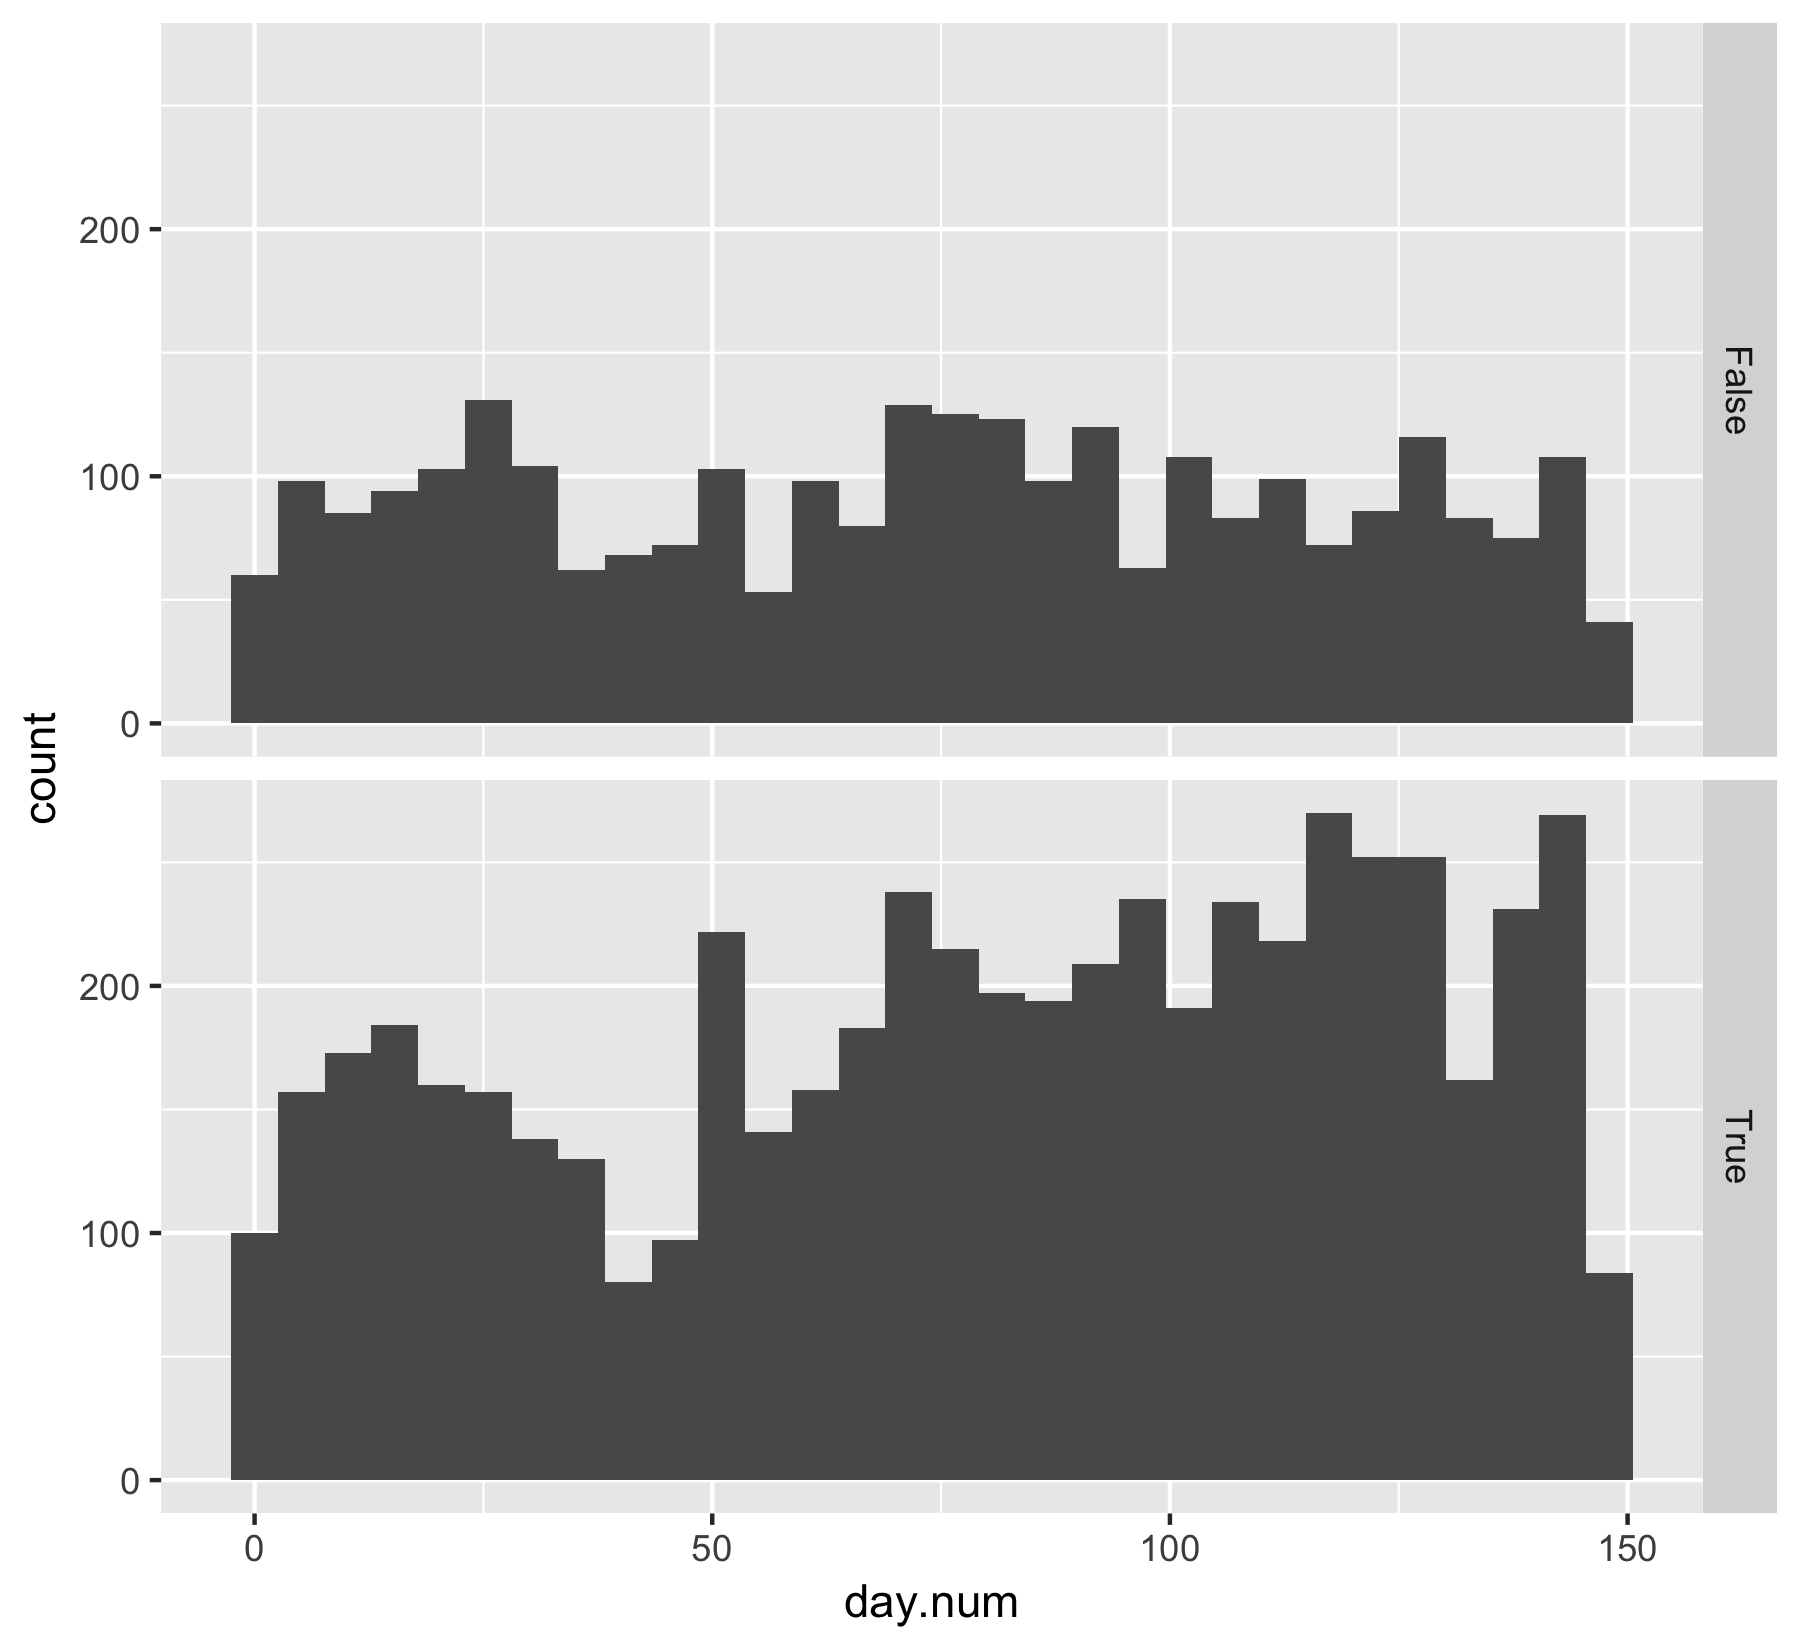

In [254]:
ggplot(exp.posts.science.2020.df, aes(day.num)) +
    geom_histogram() +
    facet_grid(visible ~ . )

In [255]:
## set up posts dataframe
exp.posts.science.2020.df$before.pandemic <- exp.posts.science.2020.df$created.date < as.Date("2020-03-11")
exp.posts.science.2020.df$before.lockdown <- exp.posts.science.2020.df$created.date >= as.Date("2020-03-15")
exp.posts.science.2020.pandemic.df <- subset(exp.posts.science.2020.df, created.date < as.Date("2020-03-11") | created.date >= as.Date("2020-03-15"))
nrow(exp.posts.science.2020.df)
nrow(exp.posts.science.2020.pandemic.df)

[1] 8271

[1] 8036

In [256]:
exp.newcomer.comments.science.2020.df$before.pandemic <- as.Date(exp.newcomer.comments.science.2020.df$post.created) < as.Date("2020-03-11")

exp.newcomer.comments.science.2020.df$before.lockdown <- as.Date(exp.newcomer.comments.science.2020.df$post.created) >= as.Date("2020-03-15")
exp.newcomer.comments.science.2020.pandemic.df <- subset(exp.newcomer.comments.science.2020.df, as.Date(post.created) < as.Date("2020-03-11") | as.Date(post.created) >= as.Date("2020-03-15"))

##### Establish the context of the analyses: declining newcomer comment counts but not overall comment counts after the lockdown

In [257]:
summary(glm.nb(newcomer.comments ~ 
               before.lockdown, 
               data= subset(exp.posts.science.2020.df, (block.id.int %in% outlier.block.ids)!=TRUE)))


summary(glm.nb(newcomer.comments ~ 
               day.num, 
               data= subset(exp.posts.science.2020.df, (block.id.int %in% outlier.block.ids)!=TRUE)))

summary(glm.nb(num.comments ~ 
               before.lockdown, 
               data= subset(exp.posts.science.2020.df, (block.id.int %in% outlier.block.ids)!=TRUE)))

summary(glm.nb(num.comments ~ 
               day.num, 
               data= subset(exp.posts.science.2020.df, (block.id.int %in% outlier.block.ids)!=TRUE)))


Call:
glm.nb(formula = newcomer.comments ~ before.lockdown, data = subset(exp.posts.science.2020.df, 
    (block.id.int %in% outlier.block.ids) != TRUE), init.theta = 0.09643923364, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0201  -0.9188  -0.9188  -0.4653   5.0352  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          3.05131    0.09871  30.911   <2e-16 ***
before.lockdownTRUE -1.02571    0.10584  -9.691   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.0964) family taken to be 1)

    Null deviance: 6038.6  on 8270  degrees of freedom
Residual deviance: 5919.3  on 8269  degrees of freedom
AIC: 31069

Number of Fisher Scoring iterations: 1


              Theta:  0.09644 
          Std. Err.:  0.00199 

 2 x log-likelihood:  -31063.00400 


Call:
glm.nb(formula = newcomer.comments ~ day.num, data = subset(exp.posts.science.2020.df, 
    (block.id.int %in% outlier.block.ids) != TRUE), init.theta = 0.0980377406, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0195  -0.9338  -0.8785  -0.4321   5.3760  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.9735486  0.0736138   40.39   <2e-16 ***
day.num     -0.0110362  0.0008268  -13.35   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.098) family taken to be 1)

    Null deviance: 6121.9  on 8270  degrees of freedom
Residual deviance: 5922.1  on 8269  degrees of freedom
AIC: 30991

Number of Fisher Scoring iterations: 1


              Theta:  0.09804 
          Std. Err.:  0.00203 

 2 x log-likelihood:  -30985.11100 


Call:
glm.nb(formula = num.comments ~ before.lockdown, data = subset(exp.posts.science.2020.df, 
    (block.id.int %in% outlier.block.ids) != TRUE), init.theta = 0.2065999897, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5649  -1.1508  -0.9528  -0.6078   7.7821  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          4.34718    0.06738  64.518   <2e-16 ***
before.lockdownTRUE -0.06179    0.07221  -0.856    0.392    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.2066) family taken to be 1)

    Null deviance: 10315  on 8270  degrees of freedom
Residual deviance: 10314  on 8269  degrees of freedom
AIC: 66401

Number of Fisher Scoring iterations: 1


              Theta:  0.20660 
          Std. Err.:  0.00279 

 2 x log-likelihood:  -66395.27800 


Call:
glm.nb(formula = num.comments ~ day.num, data = subset(exp.posts.science.2020.df, 
    (block.id.int %in% outlier.block.ids) != TRUE), init.theta = 0.2065883011, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5598  -1.1521  -0.9535  -0.6088   7.9403  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  4.3086984  0.0505701  85.203   <2e-16 ***
day.num     -0.0001933  0.0005667  -0.341    0.733    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.2066) family taken to be 1)

    Null deviance: 10315  on 8270  degrees of freedom
Residual deviance: 10315  on 8269  degrees of freedom
AIC: 66402

Number of Fisher Scoring iterations: 1


              Theta:  0.20659 
          Std. Err.:  0.00279 

 2 x log-likelihood:  -66395.90100 

In [258]:

# ggplot(exp.posts.science.2020.agg.df, aes(Group.1, num.comments)) +
#     geom_line() +
#     geom_smooth(method=lm) +
#     theme_bw()

# ggplot(exp.posts.science.2020.agg.df, aes(Group.1, newcomer.comments)) +
#     geom_line() +
#     geom_smooth(method=lm) +
#     theme_bw()

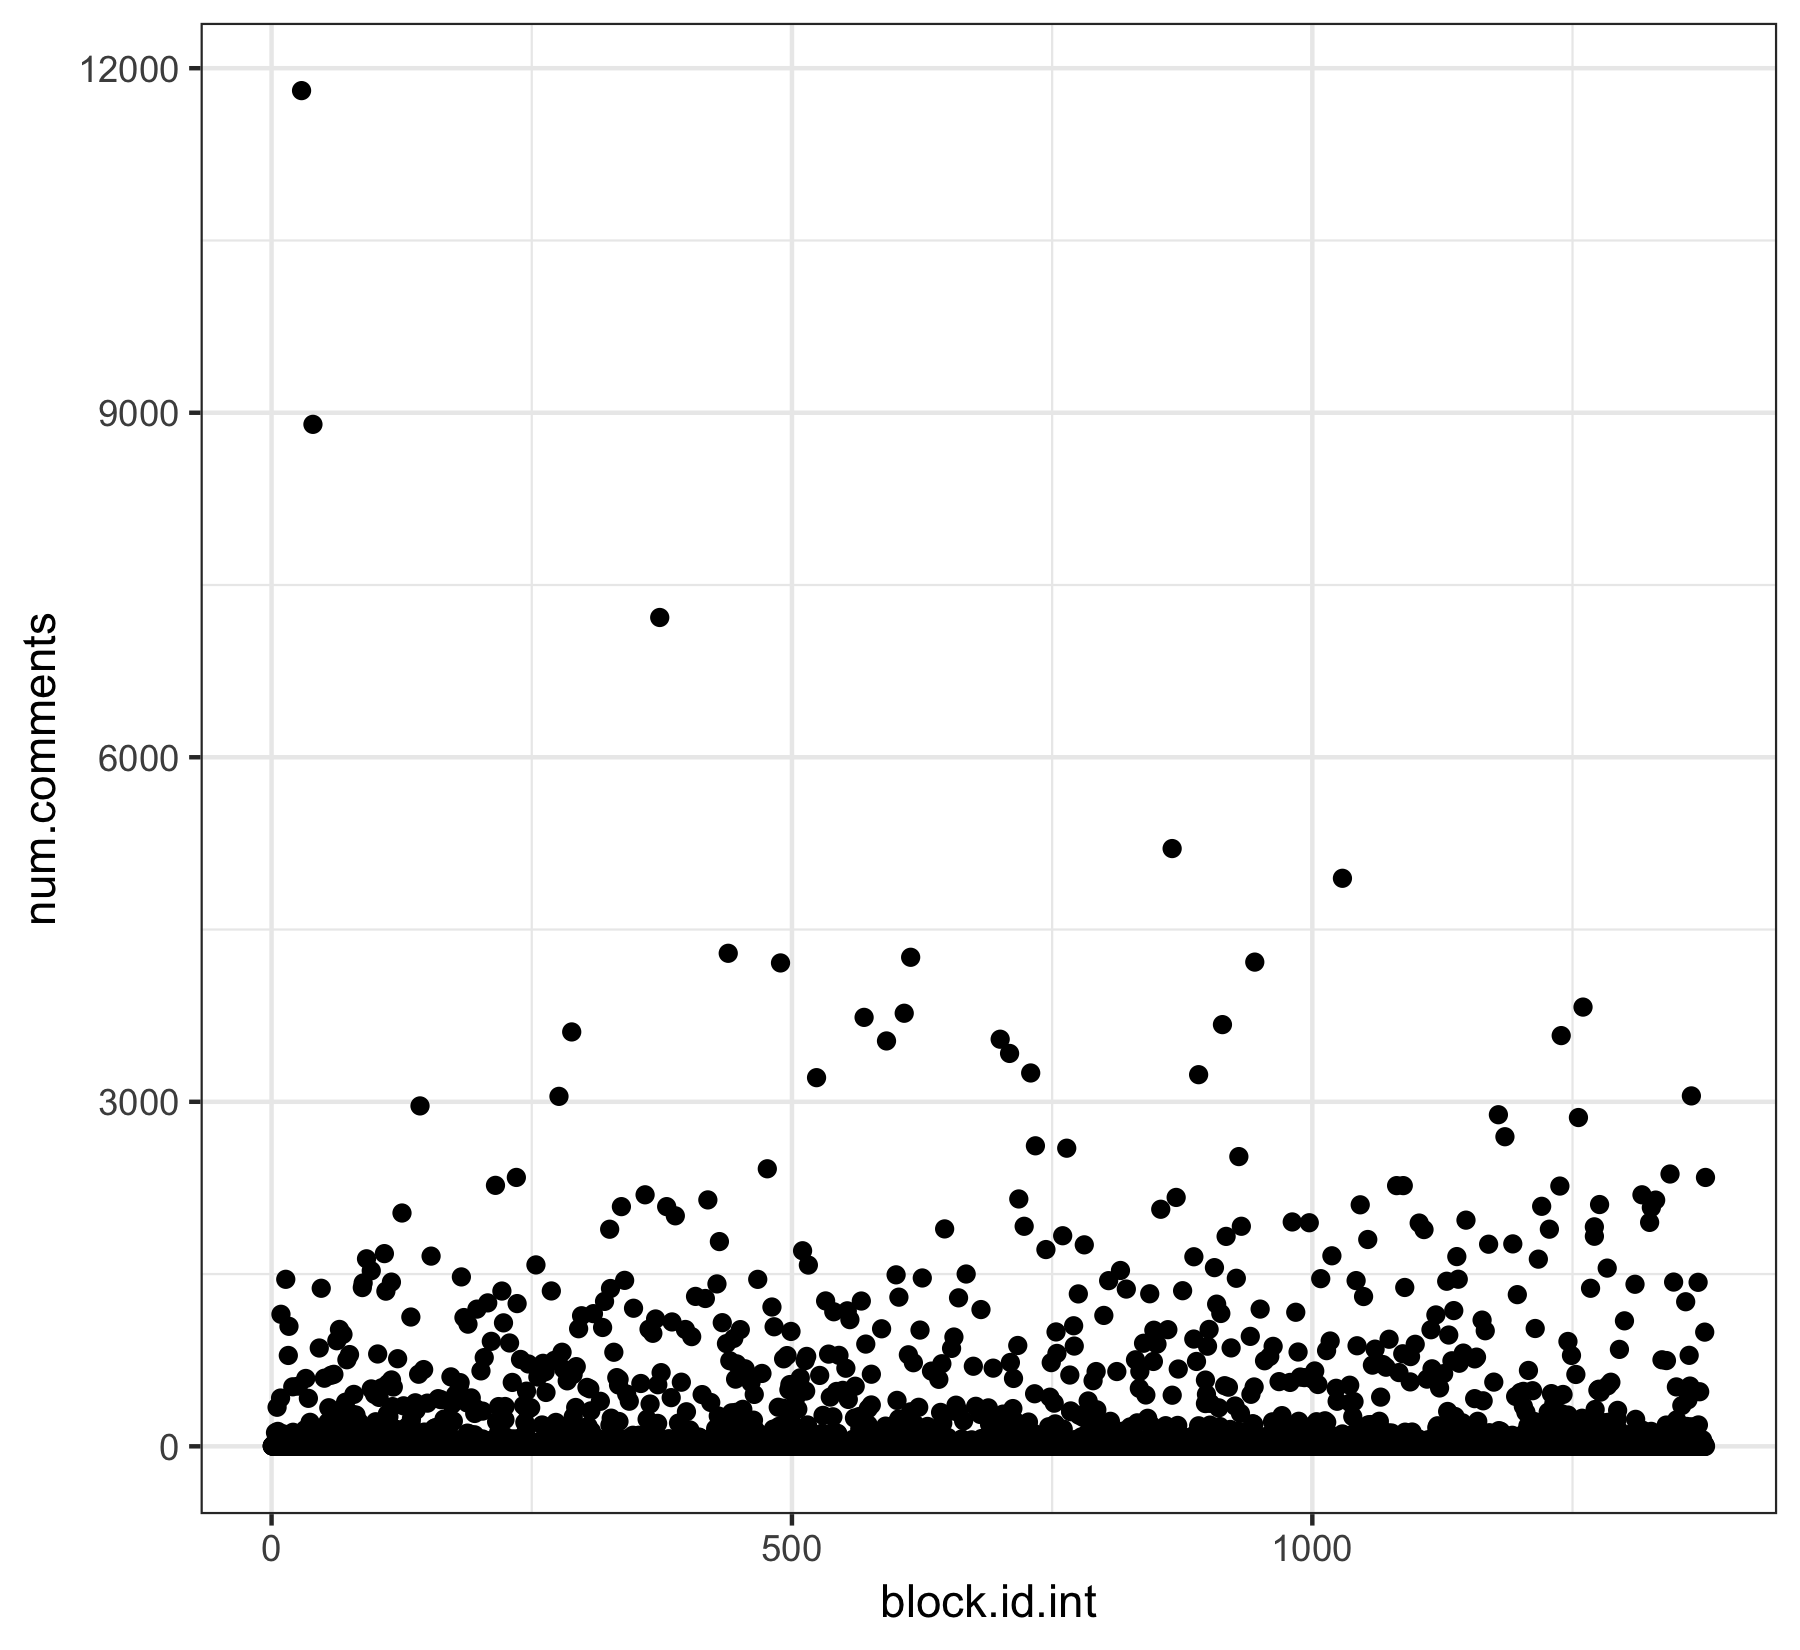

In [259]:
ggplot(exp.posts.science.2020.df, 
       aes(block.id.int, num.comments)) +
    geom_jitter() +
    theme_bw()

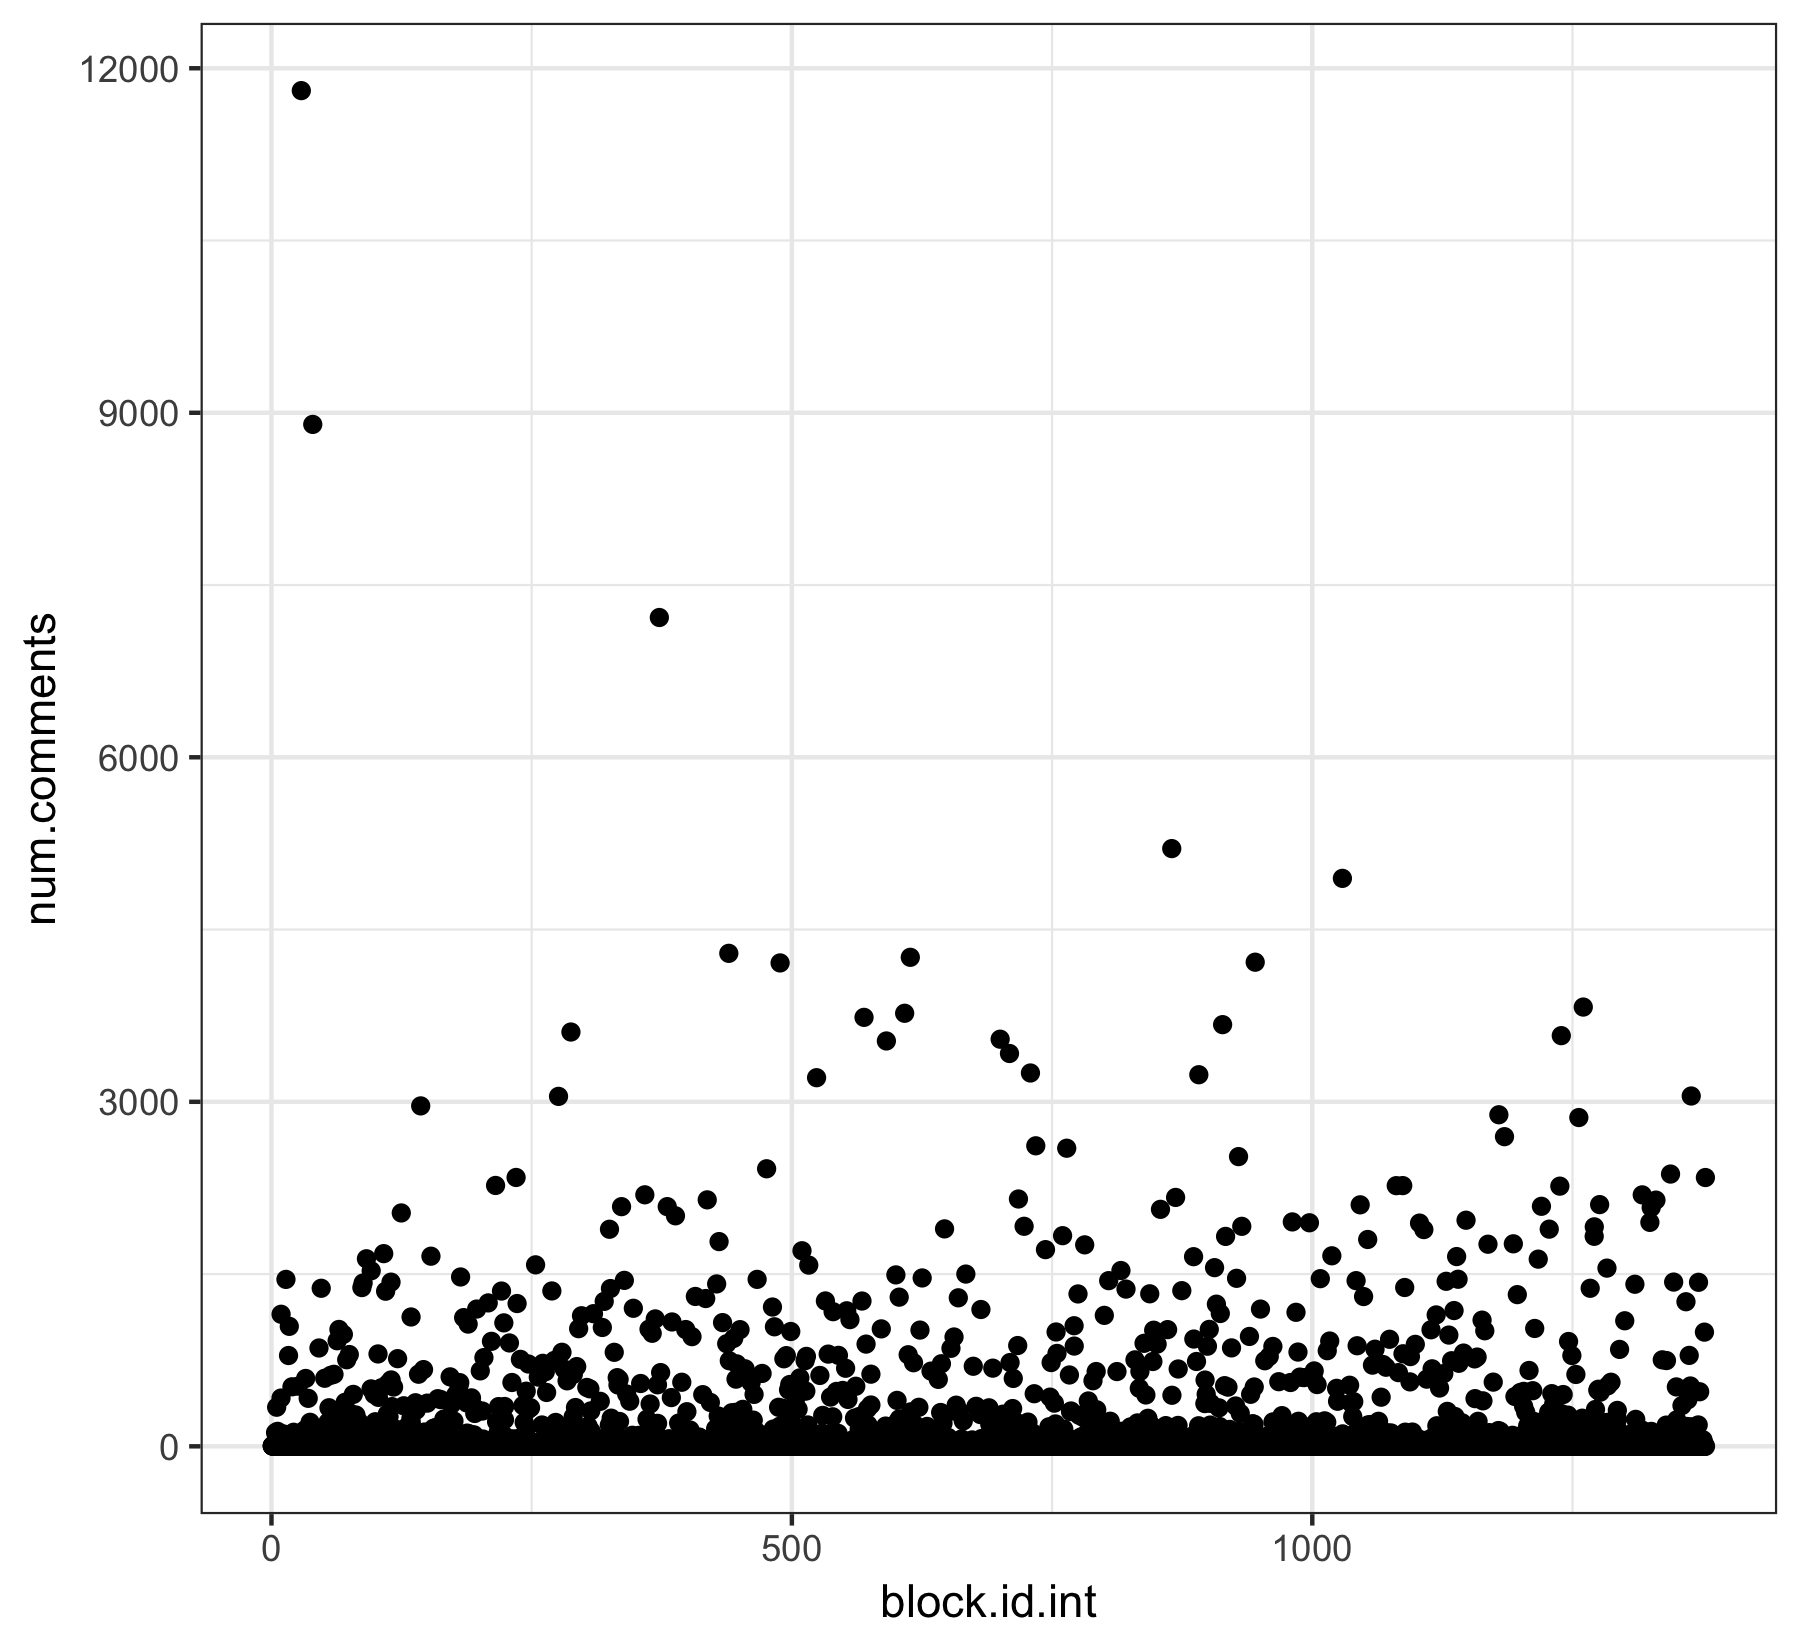

In [260]:
ggplot(exp.posts.science.2020.df, 
       aes(block.id.int, num.comments)) +
    geom_jitter() +
    theme_bw()

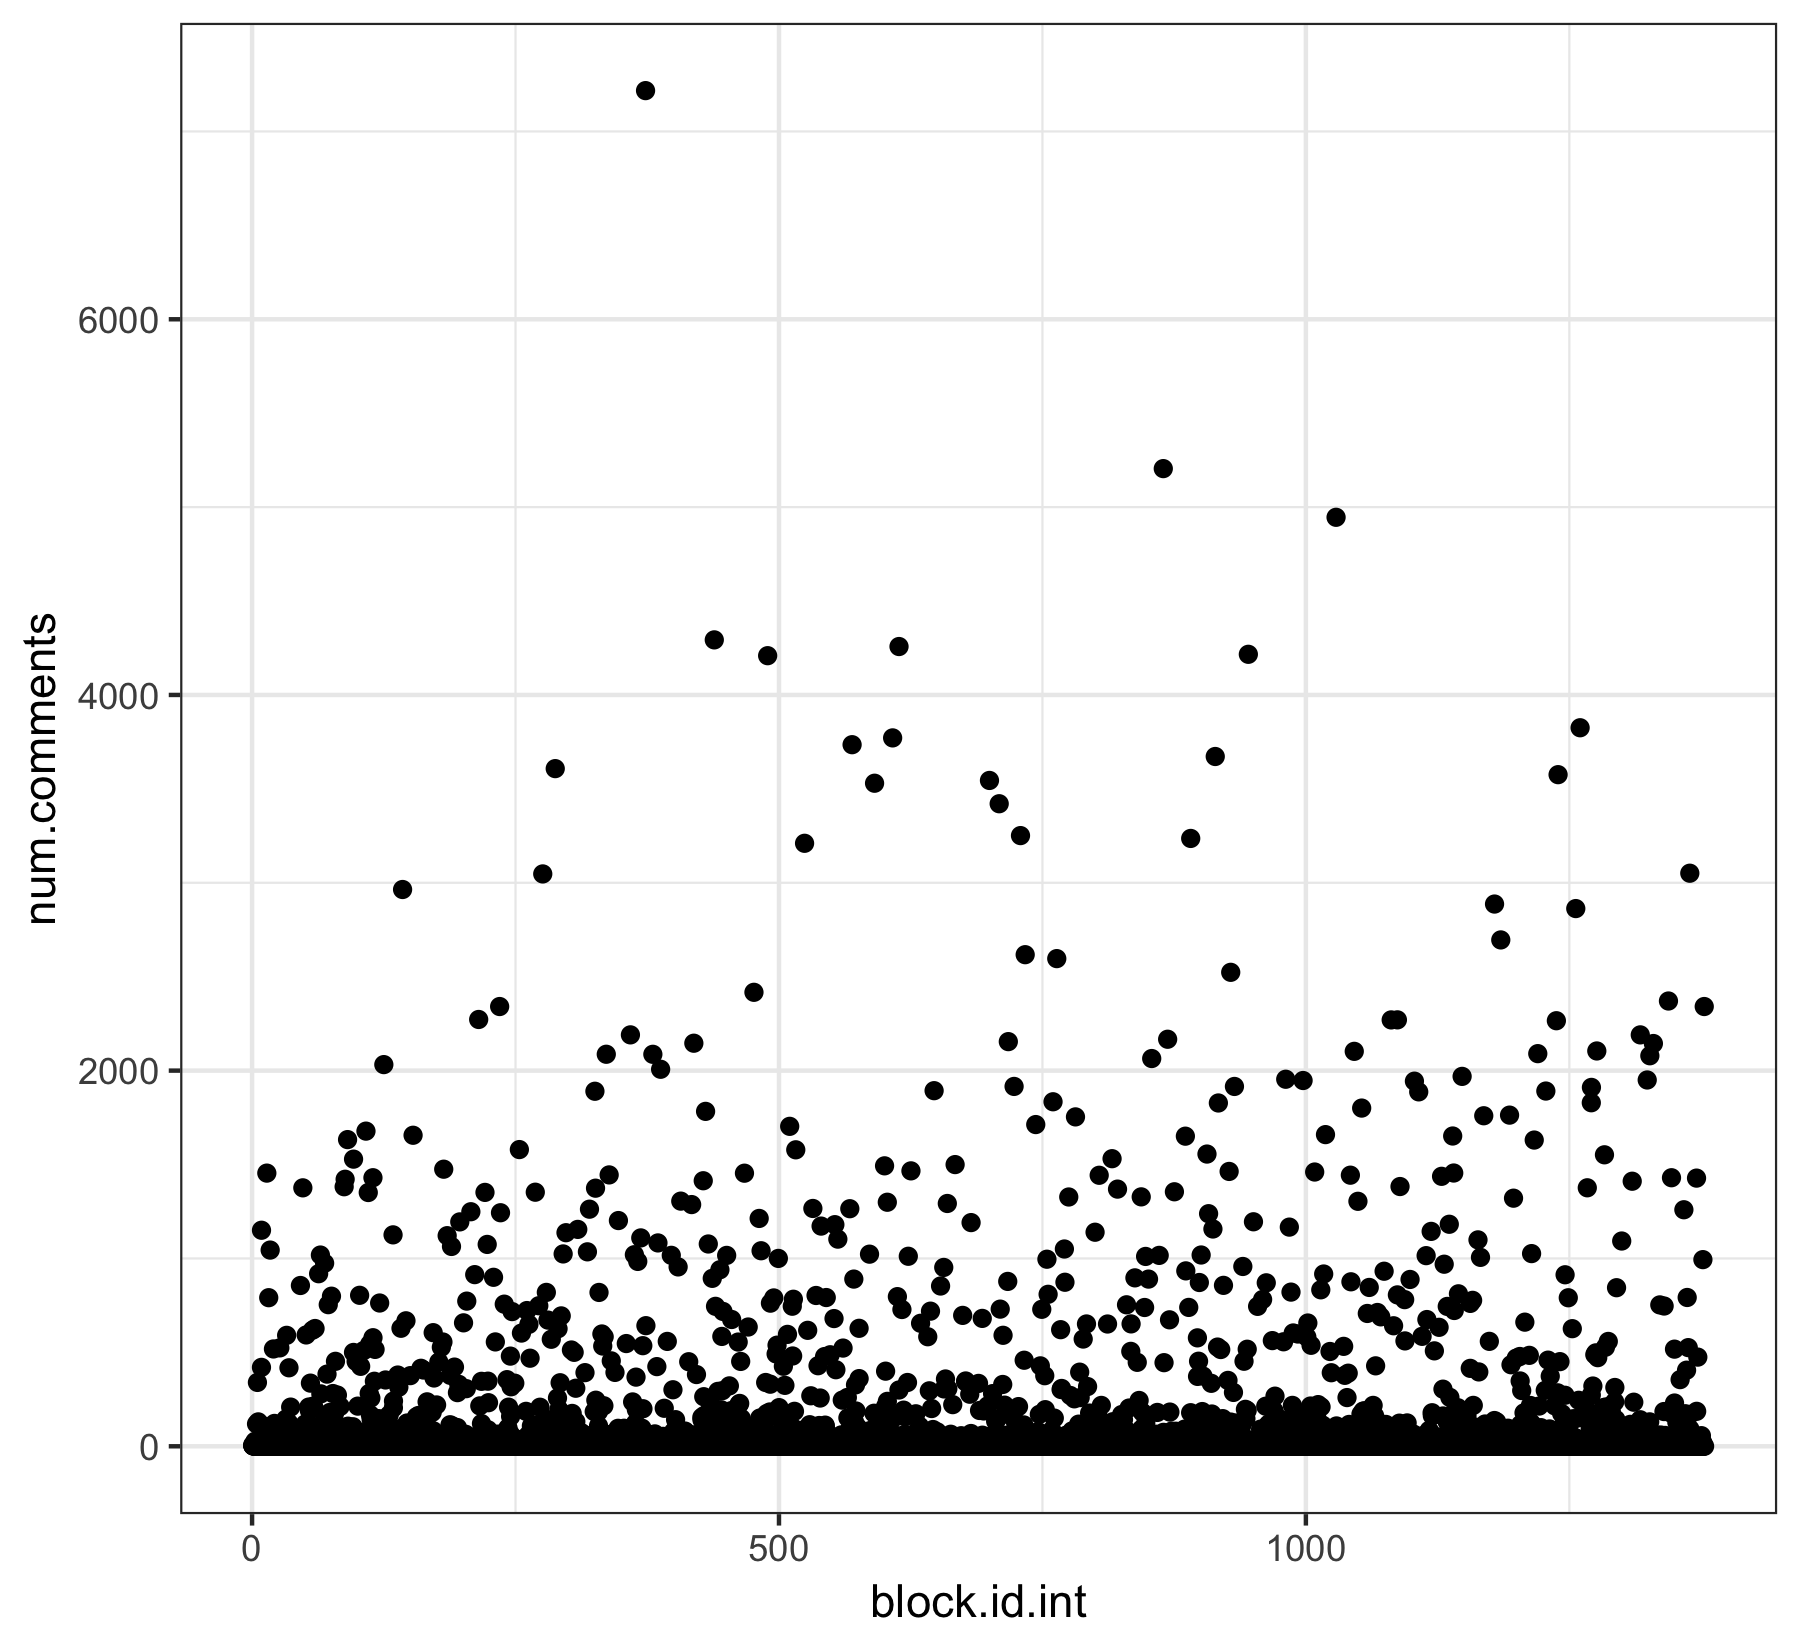

In [261]:
ggplot(subset(exp.posts.science.2020.df, (block.id %in% outlier.block.ids)!=TRUE), 
       aes(block.id.int, num.comments)) +
    geom_jitter() +
    theme_bw()

### Randomization Inference for newcomer comments removed and newcomer comments

In [262]:
ri.df     <- subset(exp.posts.science.2020.df, (block.id %in% outlier.block.ids)!=TRUE)
ri.df$Z   <- ri.df$treatment
ri.df$Y   <- ri.df$newcomer.comments.removed
ri.df.dat <- ri.df[c("block.id.int", 'Y', 'Z')]

h2.declaration <-
  with(ri.df.dat,{
    declare_ra(
      blocks = ri.df.dat$block.id.int,
      N = nrow(ri.df.dat),
      block_m = with(ri.df.dat, tapply(Z, block.id.int, sum))
    )
  })


h2.ri2_out <- conduct_ri(
  Y ~ Z,
  sharp_hypothesis = 0,
  declaration = h2.declaration,
  data = ri.df.dat,
  sims=5000,
  progress_bar=TRUE,
  p = "upper"
)
h2.ri2_out


In [26]:
ri.df     <- subset(exp.posts.science.2020.df, (block.id %in% outlier.block.ids)!=TRUE)
ri.df$Z   <- ri.df$treatment
ri.df$Y   <- ri.df$newcomer.comments
ri.df.dat <- ri.df[c("block.id.int", 'Y', 'Z')]

h3.declaration <-
  with(ri.df.dat,{
    declare_ra(
      blocks = ri.df.dat$block.id.int,
      N = nrow(ri.df.dat),
      block_m = with(ri.df.dat, tapply(Z, block.id.int, sum))
    )
  })


h3.ri2_out <- conduct_ri(
  Y ~ Z,
  sharp_hypothesis = 0,
  declaration = h3.declaration,
  data = ri.df.dat,
  sims=5000,
  progress_bar=TRUE,
  p = "upper"
)
h3.ri2_out


  term   estimate upper_p_value
1    Z -0.8439855         0.826

In [263]:
exp.newcomer.comments.science.2020.df$post.block.id.int <- as.numeric(exp.newcomer.comments.science.2020.df$post.block.id)

In [264]:
ri.df     <- subset(exp.newcomer.comments.science.2020.df, (post.block.id %in% outlier.block.ids)!=TRUE)
ri.df$Z   <- ri.df$post.treatment
ri.df$Y   <- ri.df$visible.int
ri.df.dat <- ri.df[c("post.block.id.int", 'Y', 'Z')]

h1.declaration <-
  with(ri.df.dat,{
    declare_ra(
      blocks = ri.df.dat$post.block.id.int,
      N = nrow(ri.df.dat),
      block_m = with(ri.df.dat, tapply(Z, post.block.id.int, sum))
    )
  })


h1.ri2_out <- conduct_ri(
  Y ~ Z,
  sharp_hypothesis = 0,
  declaration = h1.declaration,
  data = ri.df.dat,
  sims=5000,
  progress_bar=TRUE,
  p = "upper"
)
h1.ri2_out


# Final Combined Analysis

In [265]:
#colnames(exp.posts.science.2017.df)

In [266]:
#length(unique(exp.newcomer.comments.science.2020.df$post.assign.number))
#exp.newcomer.comments.ffxiv.df$link

In [702]:
science.2017.ma.df <- exp.posts.science.2017.df[c("num.comments", "newcomer.comments", "num.comments.removed", "newcomer.comments.removed", 'block.id', "visible", "weekend","treatment")]
science.2017.ma.df$study <- "science.2017"
science.2020.ma.df <- subset(exp.posts.science.2020.df, (block.id %in% outlier.block.ids)!=TRUE)[c("num.comments", "newcomer.comments", "num.comments.removed", "newcomer.comments.removed", 'block.id', "visible", "weekend","treatment")]
science.2020.ma.df$study <- "science.2020"
ffxiv.ma.df <- exp.posts.ffxiv.df[c("num.comments", "newcomer.comments", "num.comments.removed", "newcomer.comments.removed", 'block.id', "visible", "weekend","treatment")]
ffxiv.ma.df$study <- "ffxiv.2019"
meta.analysis.df <-  rbind(science.2017.ma.df, ffxiv.ma.df, science.2020.ma.df)


comments.science.2017.ma.df <- exp.newcomer.comments.science.2017.df[c("visible", "post.treatment", "post.visible", 'post.block.id', 'link_id')]
comments.science.2017.ma.df$study <- "science.2017"
comments.science.2020.ma.df <- subset(exp.newcomer.comments.science.2020.df, (post.block.id %in% outlier.block.ids)!=TRUE)[c("visible", "post.treatment", "post.visible", 'post.block.id', 'link_id')]
comments.science.2020.ma.df$study <- "science.2020"
comments.ffxiv.2019.ma.df   <- exp.newcomer.comments.ffxiv.df[c("visible", "post.treatment", "post.visible", 'post.block.id', 'link_id')]
comments.ffxiv.2019.ma.df$study <- "ffxiv.2019"

comments.meta.analysis.df <-  rbind(comments.science.2017.ma.df, comments.science.2020.ma.df, comments.ffxiv.2019.ma.df)

In [703]:
generate.result.table <- function(model.obj, model.name, treat.var, n.size, p.var="Pr(>|z|)"){

    m.summary <- summary(model.obj)
    m.df = data.frame(
        model.name            = model.name,
        treat.estimate        = m.summary$coefficients[treat.var,][['Estimate']],
        treat.estimate.stderr = m.summary$coefficients[treat.var,][['Std. Error']],
        treat.estimate.pvalue = m.summary$coefficients[treat.var,][[p.var]],
        n.size                = n.size
    )
    m.df$treat.estimate.upr <- m.df$treat.estimate + critval * m.df$treat.estimate.stderr
    m.df$treat.estimate.lwr <- m.df$treat.estimate - critval * m.df$treat.estimate.stderr

    m.df$treat.estimate.irr.upr <- exp(m.df$treat.estimate + critval * m.df$treat.estimate.stderr)
    m.df$treat.estimate.irr.lwr <- exp(m.df$treat.estimate - critval * m.df$treat.estimate.stderr)
    m.df$treat.estimate.irr <- exp(m.df$treat.estimate)
    return (m.df)
    
}

# ## test function
# rbind(generate.result.table(h3.science.2017.m, "science.2017", "treatment", nrow(exp.posts.science.2017.df)),
#       generate.result.table(h3.science.2017.m, "science.2017", "treatment", nrow(exp.posts.science.2017.df)))

### Chance of Comment Removal

In [704]:
comments.science.2017.ma.df$visible.int <- comments.science.2017.ma.df$visible=="True"
comments.science.2020.ma.df$visible.int <- comments.science.2020.ma.df$visible=="True"
comments.ffxiv.2019.ma.df$visible.int   <- comments.ffxiv.2019.ma.df$visible=="True"
comments.meta.analysis.df$visible.int   <- comments.meta.analysis.df$visible=="True"

In [719]:
## Random Effects Model (as in the PNAS article)

# m1.science.2017.re <- lmer(visible.int ~ post.treatment + post.visible + (1|link_id), 
#               data=comments.science.2017.ma.df) #, method="binomial")

# m1.ffxiv.2019.re <- lmer(visible.int ~ post.treatment + post.visible + (1|link_id), 
#               data=comments.ffxiv.2019.ma.df) #, method="binomial")

# m1.science.2020.re <- lmer(visible.int ~ post.treatment + post.visible + (1|link_id), 
#               data=comments.science.2020.ma.df) #, method="binomial")

m1.all.re <- lmer(visible.int ~ post.treatment + post.visible + (1|link_id/study), 
              data=comments.meta.analysis.df) #, method="binomial")


#print(screenreg(list(m1.all.re)))
summary(m1.all.re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: visible.int ~ post.treatment + post.visible + (1 | link_id/study)
   Data: comments.meta.analysis.df

REML criterion at convergence: 192529.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2932 -1.0218  0.3443  0.7319  2.2342 

Random effects:
 Groups        Name        Variance Std.Dev.
 study:link_id (Intercept) 0.01606  0.1267  
 link_id       (Intercept) 0.01401  0.1183  
 Residual                  0.18669  0.4321  
Number of obs: 161665, groups:  study:link_id, 9528; link_id, 9528

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      7.194e-01  7.609e-03 8.564e+03   94.55   <2e-16 ***
post.treatment   1.724e-02  6.456e-03 9.365e+03    2.67   0.0076 ** 
post.visibleTrue 1.079e-01  7.798e-03 8.724e+03   13.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       

In [706]:
h1.dim.science.2016 <- difference_in_means(visible.int ~ post.treatment, 
                        data=comments.science.2017.ma.df, 
                        clusters=comments.science.2017.ma.df$link_id)

h1.dim.ffxiv.2019   <- difference_in_means(visible.int ~ post.treatment, 
                        data=comments.ffxiv.2019.ma.df, 
                        clusters=comments.ffxiv.2019.ma.df$link_id)

h1.dim.science.2020 <- difference_in_means(visible.int ~ post.treatment, 
                        data=comments.science.2020.ma.df, 
                        clusters=comments.science.2020.ma.df$link_id)

#### Generate Table for illustration

In [707]:
## random effects
# h1.plot.re.df <- rbind(
#     generate.result.table(m1.science.2017.re, "science.2016", "post.treatment", nrow(exp.posts.science.2017.df), "Pr(>|t|)"),
#     generate.result.table(m1.ffxiv.2019.re,   "ffxiv.2019",   "post.treatment", nrow(exp.posts.ffxiv.df), "Pr(>|t|)"),
#     generate.result.table(m1.science.2020.re, "science.2020", "post.treatment", nrow(exp.posts.science.2020.df), "Pr(>|t|)")
# )

h1.plot.dim.df <- data.frame(rbind(
    summary(h1.dim.science.2016)$coefficients,
    summary(h1.dim.ffxiv.2019)$coefficients,
    summary(h1.dim.science.2020)$coefficients
))

h1.plot.dim.df$model.name <- c("science.2016","ffxiv.2019", "science.2020")
h1.plot.dim.df$treat.estimate <- h1.plot.dim.df[['Estimate']]
h1.plot.dim.df$treat.estimate.pvalue <- h1.plot.dim.df[['Pr...t..']]
h1.plot.dim.df$treat.estimate.upr <- h1.plot.dim.df$CI.Upper
h1.plot.dim.df$treat.estimate.lwr <- h1.plot.dim.df$CI.Lower

h1.plot.re.ma.df <- generate.result.table(m1.all.re, "all", "post.treatment", nrow(comments.meta.analysis.df),"Pr(>|t|)") 
    

In [708]:
h1.plot.dim.df

,Estimate,Std..Error,t.value,Pr...t..,CI.Lower,CI.Upper,DF,model.name,treat.estimate,treat.estimate.pvalue,treat.estimate.upr,treat.estimate.lwr
post.treatment,0.074841660,0.052115088,1.4360843,0.15737094,-0.029903755,0.179587076,48.70174,science.2016,0.074841660,0.15737094,0.179587076,-0.029903755
post.treatment.1,-0.001145166,0.002862479,-0.4000611,0.68923914,-0.006765681,0.004475348,669.63565,ffxiv.2019,-0.001145166,0.68923914,0.004475348,-0.006765681
post.treatment.2,0.043742943,0.018972040,2.3056531,0.02173314,0.006425205,0.081060682,339.01739,science.2020,0.043742943,0.02173314,0.081060682,0.006425205


### Newcomer Comments

In [709]:
h3.science.2017.m <- glm.nb(newcomer.comments ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="science.2017") )

h3.science.2020.m <- glm.nb(newcomer.comments ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="science.2020") )
h3.ffxiv.2019.m   <- glm.nb(newcomer.comments ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="ffxiv.2019") )

print(screenreg(list(h3.science.2017.m, h3.ffxiv.2019.m, h3.science.2020.m)))

h3.plot.df <- rbind(
    generate.result.table(h3.science.2017.m, "science.2016", "treatment", nrow(exp.posts.science.2017.df)),
    generate.result.table(h3.ffxiv.2019.m,   "ffxiv.2019",   "treatment", nrow(exp.posts.ffxiv.df)),
    generate.result.table(h3.science.2020.m, "science.2020", "treatment", nrow(exp.posts.science.2020.df))
)


                Model 1       Model 2        Model 3      
----------------------------------------------------------
(Intercept)         1.28 ***      -0.82 ***       1.74 ***
                   (0.13)         (0.07)         (0.07)   
treatment           0.51 ***      -0.03          -0.11    
                   (0.14)         (0.04)         (0.07)   
visibleTrue         0.85 ***       0.91 ***       0.65 ***
                   (0.14)         (0.07)         (0.08)   
----------------------------------------------------------
AIC              7554.73       30786.91       30890.87    
BIC              7577.54       30816.52       30918.94    
Log Likelihood  -3773.36      -15389.46      -15441.43    
Deviance         1533.26        9224.89        5901.69    
Num. obs.        2214          12100           8259       
*** p < 0.001, ** p < 0.01, * p < 0.05


### Newcomer Comments Removed

In [710]:
h2.science.2017.m <- glm.nb(newcomer.comments.removed ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="science.2017") )

h2.science.2020.m <- glm.nb(newcomer.comments.removed ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="science.2020") )
h2.ffxiv.2019.m   <- glm.nb(newcomer.comments.removed ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="ffxiv.2019") )

print(screenreg(list(h2.science.2017.m, h2.ffxiv.2019.m, h2.science.2020.m)))



h2.plot.df <- rbind(
    generate.result.table(h2.science.2017.m, "science.2016", "treatment", nrow(exp.posts.science.2017.df)),
    generate.result.table(h2.ffxiv.2019.m,   "ffxiv.2019",   "treatment", nrow(exp.posts.ffxiv.df)),
    generate.result.table(h2.science.2020.m, "science.2020", "treatment", nrow(exp.posts.science.2020.df))
)


                Model 1       Model 2       Model 3     
--------------------------------------------------------
(Intercept)         0.78 ***     -4.38 ***      0.66 ***
                   (0.17)        (0.37)        (0.10)   
treatment           0.36 *        0.04         -0.24 *  
                   (0.18)        (0.21)        (0.10)   
visibleTrue         0.75 ***      0.04          0.80 ***
                   (0.19)        (0.37)        (0.11)   
--------------------------------------------------------
AIC              5071.01       1520.77      17646.80    
BIC              5093.82       1550.38      17674.88    
Log Likelihood  -2531.51       -756.39      -8819.40    
Deviance         1006.09        486.01       3380.94    
Num. obs.        2214         12100          8259       
*** p < 0.001, ** p < 0.01, * p < 0.05


In [711]:
h2.plot.df

model.name,treat.estimate,treat.estimate.stderr,treat.estimate.pvalue,n.size,treat.estimate.upr,treat.estimate.lwr,treat.estimate.irr.upr,treat.estimate.irr.lwr,treat.estimate.irr
science.2016,0.36484529,0.18457447,0.04807743,2214,0.72661124,0.003079333,2.0680606,1.0030841,1.4402912
ffxiv.2019,0.03765837,0.20956763,0.85739159,12100,0.44841093,-0.373094190,1.5658220,0.6886004,1.0383764
science.2020,-0.23979811,0.09874289,0.01516100,8271,-0.04626206,-0.433334172,0.9547917,0.6483438,0.7867867


## Adjust P Values

In [712]:
science.2017.pvalues <- data.frame(hypothesis = c("h1", "h2", "h3"),
                         pvalue    = c(
                             h1.plot.dim.df[h1.plot.dim.df$model.name=="science.2016",][['treat.estimate.pvalue']],
                             h2.plot.df[h2.plot.df$model.name=="science.2016",][['treat.estimate.pvalue']],
                             h3.plot.df[h3.plot.df$model.name=="science.2016",][['treat.estimate.pvalue']]
                         ))
science.2017.pvalues$adjusted <- p.adjust(science.2017.pvalues$pvalue, method="holm")

science.2017.pvalues <- data.frame(hypothesis = c("h1", "h2", "h3"),
                         pvalue    = c(
                             h1.plot.dim.df[h1.plot.dim.df$model.name=="science.2016",][['treat.estimate.pvalue']],
                             h2.plot.df[h2.plot.df$model.name=="science.2016",][['treat.estimate.pvalue']],
                             h3.plot.df[h3.plot.df$model.name=="science.2016",][['treat.estimate.pvalue']]
                         ))
science.2017.pvalues$adjusted <- p.adjust(science.2017.pvalues$pvalue, method="holm")

science.2017.pvalues

science.2020.pvalues <- data.frame(hypothesis = c("h1", "h2", "h3"),
                         pvalue    = c(
                             h1.plot.dim.df[h1.plot.dim.df$model.name=="science.2020",][['treat.estimate.pvalue']],
                             h2.plot.df[h2.plot.df$model.name=="science.2020",][['treat.estimate.pvalue']],
                             h3.plot.df[h3.plot.df$model.name=="science.2020",][['treat.estimate.pvalue']]
                         ))
science.2020.pvalues$adjusted <- p.adjust(science.2020.pvalues$pvalue, method="holm")
science.2020.pvalues

ffxiv.2019.pvalues <- data.frame(hypothesis = c("h1", "h2", "h3"),
                         pvalue    = c(
                             h1.plot.dim.df[h1.plot.dim.df$model.name=="ffxiv.2019",][['treat.estimate.pvalue']],
                             h2.plot.df[h2.plot.df$model.name=="ffxiv.2019",][['treat.estimate.pvalue']],
                             h3.plot.df[h3.plot.df$model.name=="ffxiv.2019",][['treat.estimate.pvalue']]
                         ))
ffxiv.2019.pvalues$adjusted <- p.adjust(ffxiv.2019.pvalues$pvalue, method="holm")
ffxiv.2019.pvalues


hypothesis,pvalue,adjusted
h1,0.1573709440,0.157370944
h2,0.0480774262,0.096154852
h3,0.0003593747,0.001078124


hypothesis,pvalue,adjusted
h1,0.02173314,0.04548299
h2,0.01516100,0.04548299
h3,0.12891504,0.12891504


hypothesis,pvalue,adjusted
h1,0.6892391,1
h2,0.8573916,1
h3,0.4423987,1


# Final Plots
## H1: Newcomer Compliance

In [713]:
h1.plot.dim.df$model.name <- factor(h1.plot.dim.df$model.name, levels=c("science.2016", "ffxiv.2019", "science.2020"))

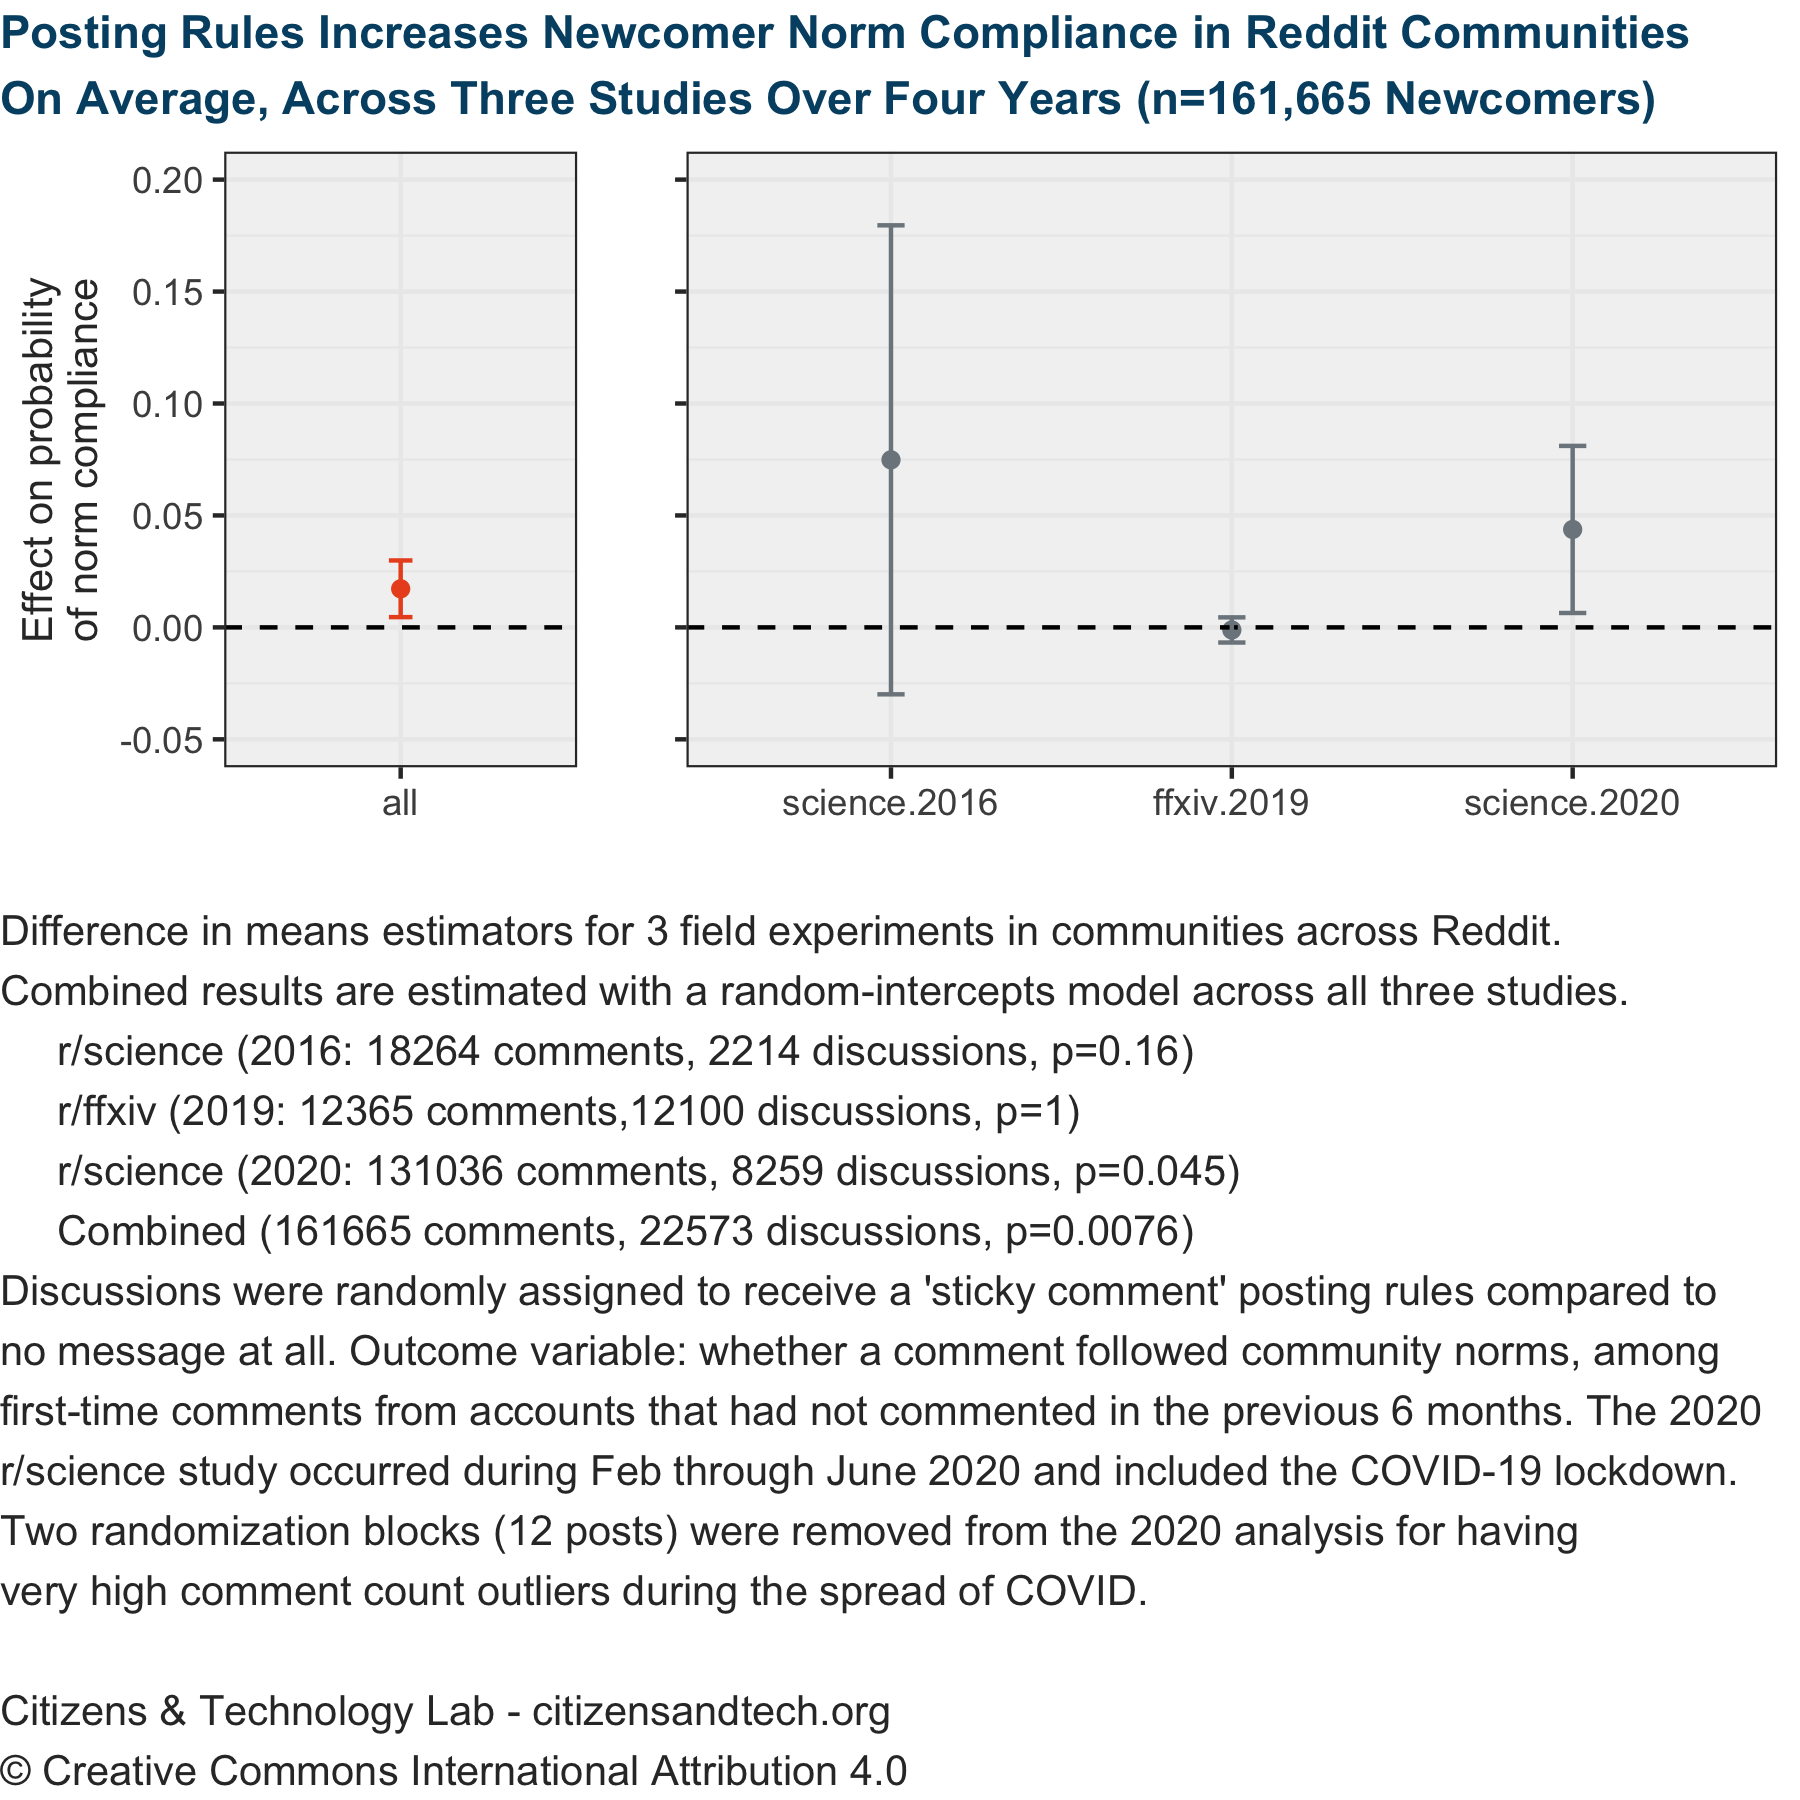

In [714]:
options(repr.plot.width = 6, repr.plot.height = 6)


h1.plot.individ <- ggplot(h1.plot.dim.df, aes(model.name, treat.estimate)) +
    geom_point(color=chartpalette[3]) +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_errorbar(ymin=h1.plot.dim.df$treat.estimate.lwr, 
                  ymax=h1.plot.dim.df$treat.estimate.upr,
                  width=0.08,color=chartpalette[3]) +
    ylim(-0.05,0.2) +
    xlab("") +
    ylab("") +
    cat.theme +
    theme(axis.text.y=element_blank())

#h1.plot.individ

h1.plot.ma <- ggplot(h1.plot.re.ma.df, aes(model.name, treat.estimate)) +
    geom_point(color=chartpalette[1]) +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_errorbar(ymin=h1.plot.re.ma.df$treat.estimate.lwr, 
                  ymax=h1.plot.re.ma.df$treat.estimate.upr,
                  width=0.08,color=chartpalette[1]) +
    ylim(-0.05,0.2) +
    xlab("") +
    ylab(paste("Effect on probability\n","of norm compliance", sep="")) +
    cat.theme


x.just = 0
h.just = 0

h1.plot.title <- paste("Posting Rules Increases Newcomer Norm Compliance in Reddit Communities\n", 
                       "On Average, Across Three Studies Over Four Years (n=",prettyNum(nrow(comments.meta.analysis.df), big.mark=",")," Newcomers)", sep="")


h1.caption.text <- paste("Difference in means estimators for 3 field experiments in communities across Reddit.\n", 
                         "Combined results are estimated with a random-intercepts model across all three studies.\n",
                           "     r/science (2016: ",nrow(comments.science.2017.ma.df)," comments, ",
                           nrow(subset(meta.analysis.df, study=="science.2017"))," discussions, p=",
                           prettyNum(subset(science.2017.pvalues, hypothesis=="h1")$adjusted, digits=2), ")\n",
                           "     r/ffxiv (2019: ", nrow(comments.ffxiv.2019.ma.df),
                           " comments,", nrow(subset(meta.analysis.df, study=="ffxiv.2019"))," discussions, p=",
                          prettyNum(subset(ffxiv.2019.pvalues, hypothesis=="h1")$adjusted, digits=2), ")\n", 
                           "     r/science (2020: ", nrow(comments.science.2020.ma.df), " comments, ",
                           nrow(subset(meta.analysis.df, study=="science.2020")), " discussions, p=",
                           prettyNum(subset(science.2020.pvalues, hypothesis=="h1")$adjusted, digits=2),                    
                           ")\n",
                           "     Combined (", nrow(comments.meta.analysis.df), " comments, ", nrow(meta.analysis.df), " discussions, p=",
                             prettyNum(h1.plot.re.ma.df$treat.estimate.pvalue, digits=2)
                         ,")\n",
                   "Discussions were randomly assigned to receive a 'sticky comment' posting rules compared to\n", 
                   "no message at all. Outcome variable: whether a comment followed community norms, among\n",
                   "first-time comments from accounts that had not commented in the previous 6 months. The 2020\n",
                   "r/science study occurred during Feb through June 2020 and included the COVID-19 lockdown.\n",
                   "Two randomization blocks (12 posts) were removed from the 2020 analysis for having\n",
                   "very high comment count outliers during the spread of COVID.",
                   end.caption.text,
                         sep="")


h1.plot.combined <- ggarrange(h1.plot.ma, h1.plot.individ, ncol=2, nrow=1, widths=c(1,2))
h1.plot.combined <- annotate_figure(h1.plot.combined,
                                    top    = text_grob(
                                             h1.plot.title,
                                             hjust=h.just, x=x.just, size=11,
                                             face="bold",
                                             color=chartpalette[2]),
                                    bottom = text_grob(h1.caption.text,
                                                       hjust=h.just, x=x.just, size=10,
                                                       color=chartpalette[4]))

h1.plot.combined

## H2: Newcomer Comments Removed

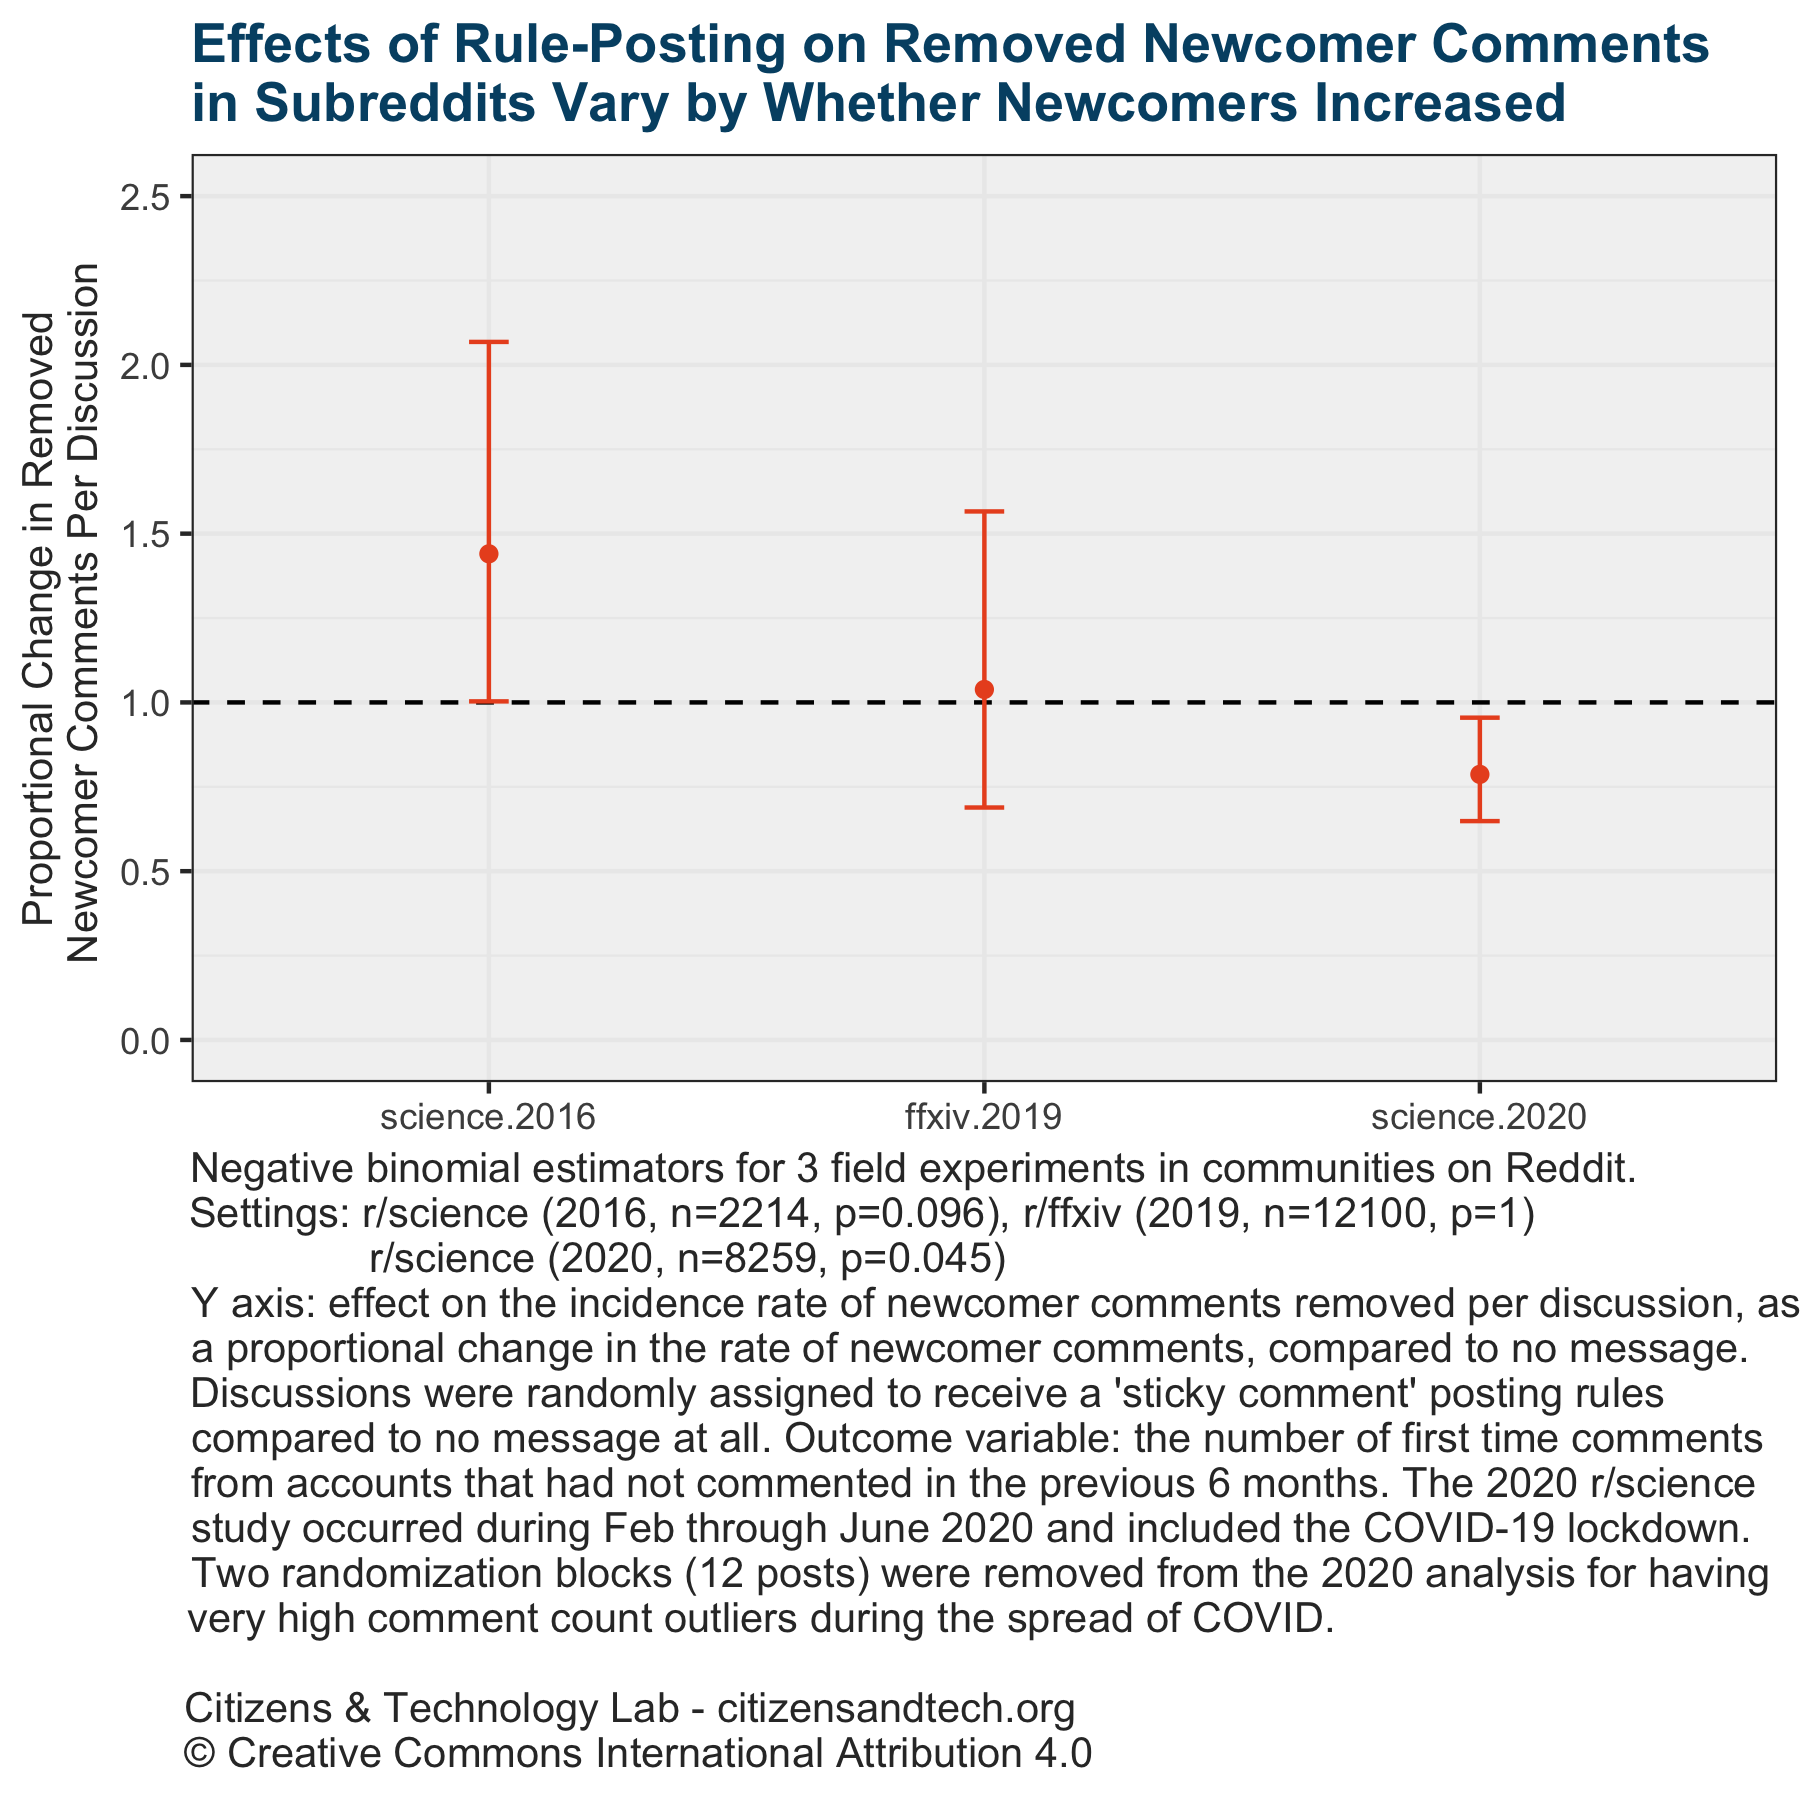

In [715]:
ggplot(h2.plot.df, aes(model.name, treat.estimate.irr)) +
    geom_point(color=chartpalette[1]) +
    geom_hline(yintercept=1, linetype="dashed") +
    geom_errorbar(ymin=h2.plot.df$treat.estimate.irr.lwr, 
                  ymax=h2.plot.df$treat.estimate.irr.upr,
                  width=0.08,color=chartpalette[1]) +
    ylim(0, 2.5)  +
    cat.theme +
    ylab("Proportional Change in Removed\n Newcomer Comments Per Discussion") +
    ggtitle(paste("Effects of Rule-Posting on Removed Newcomer Comments\n",
                  "in Subreddits Vary by Whether Newcomers Increased", sep="")) +
    xlab(paste("Negative binomial estimators for 3 field experiments in communities on Reddit.\n",
               "Settings: r/science (2016, n=",nrow(subset(meta.analysis.df, study=="science.2017")),
               ", p=",prettyNum(subset(science.2017.pvalues, hypothesis=="h2")$adjusted, digits=2), 
               "), r/ffxiv (2019, n=", nrow(subset(meta.analysis.df, study=="ffxiv.2019")),
               ", p=",prettyNum(subset(ffxiv.2019.pvalues, hypothesis=="h2")$adjusted, digits=2), 
               ")\n                r/science (2020, n=", nrow(subset(meta.analysis.df, study=="science.2020")), 
               ", p=",prettyNum(subset(science.2020.pvalues, hypothesis=="h2")$adjusted, digits=2),                    
               ")\n", 
               "Y axis: effect on the incidence rate of newcomer comments removed per discussion, as\n",
               "a proportional change in the rate of newcomer comments, compared to no message.\n",
               "Discussions were randomly assigned to receive a 'sticky comment' posting rules\n", 
               "compared to no message at all. Outcome variable: the number of first time comments\n",
               "from accounts that had not commented in the previous 6 months. The 2020 r/science\n",
               "study occurred during Feb through June 2020 and included the COVID-19 lockdown.\n",
               "Two randomization blocks (12 posts) were removed from the 2020 analysis for having\n",
               "very high comment count outliers during the spread of COVID.",
               end.caption.text,
               sep=""))


## H3: Newcomer Comments

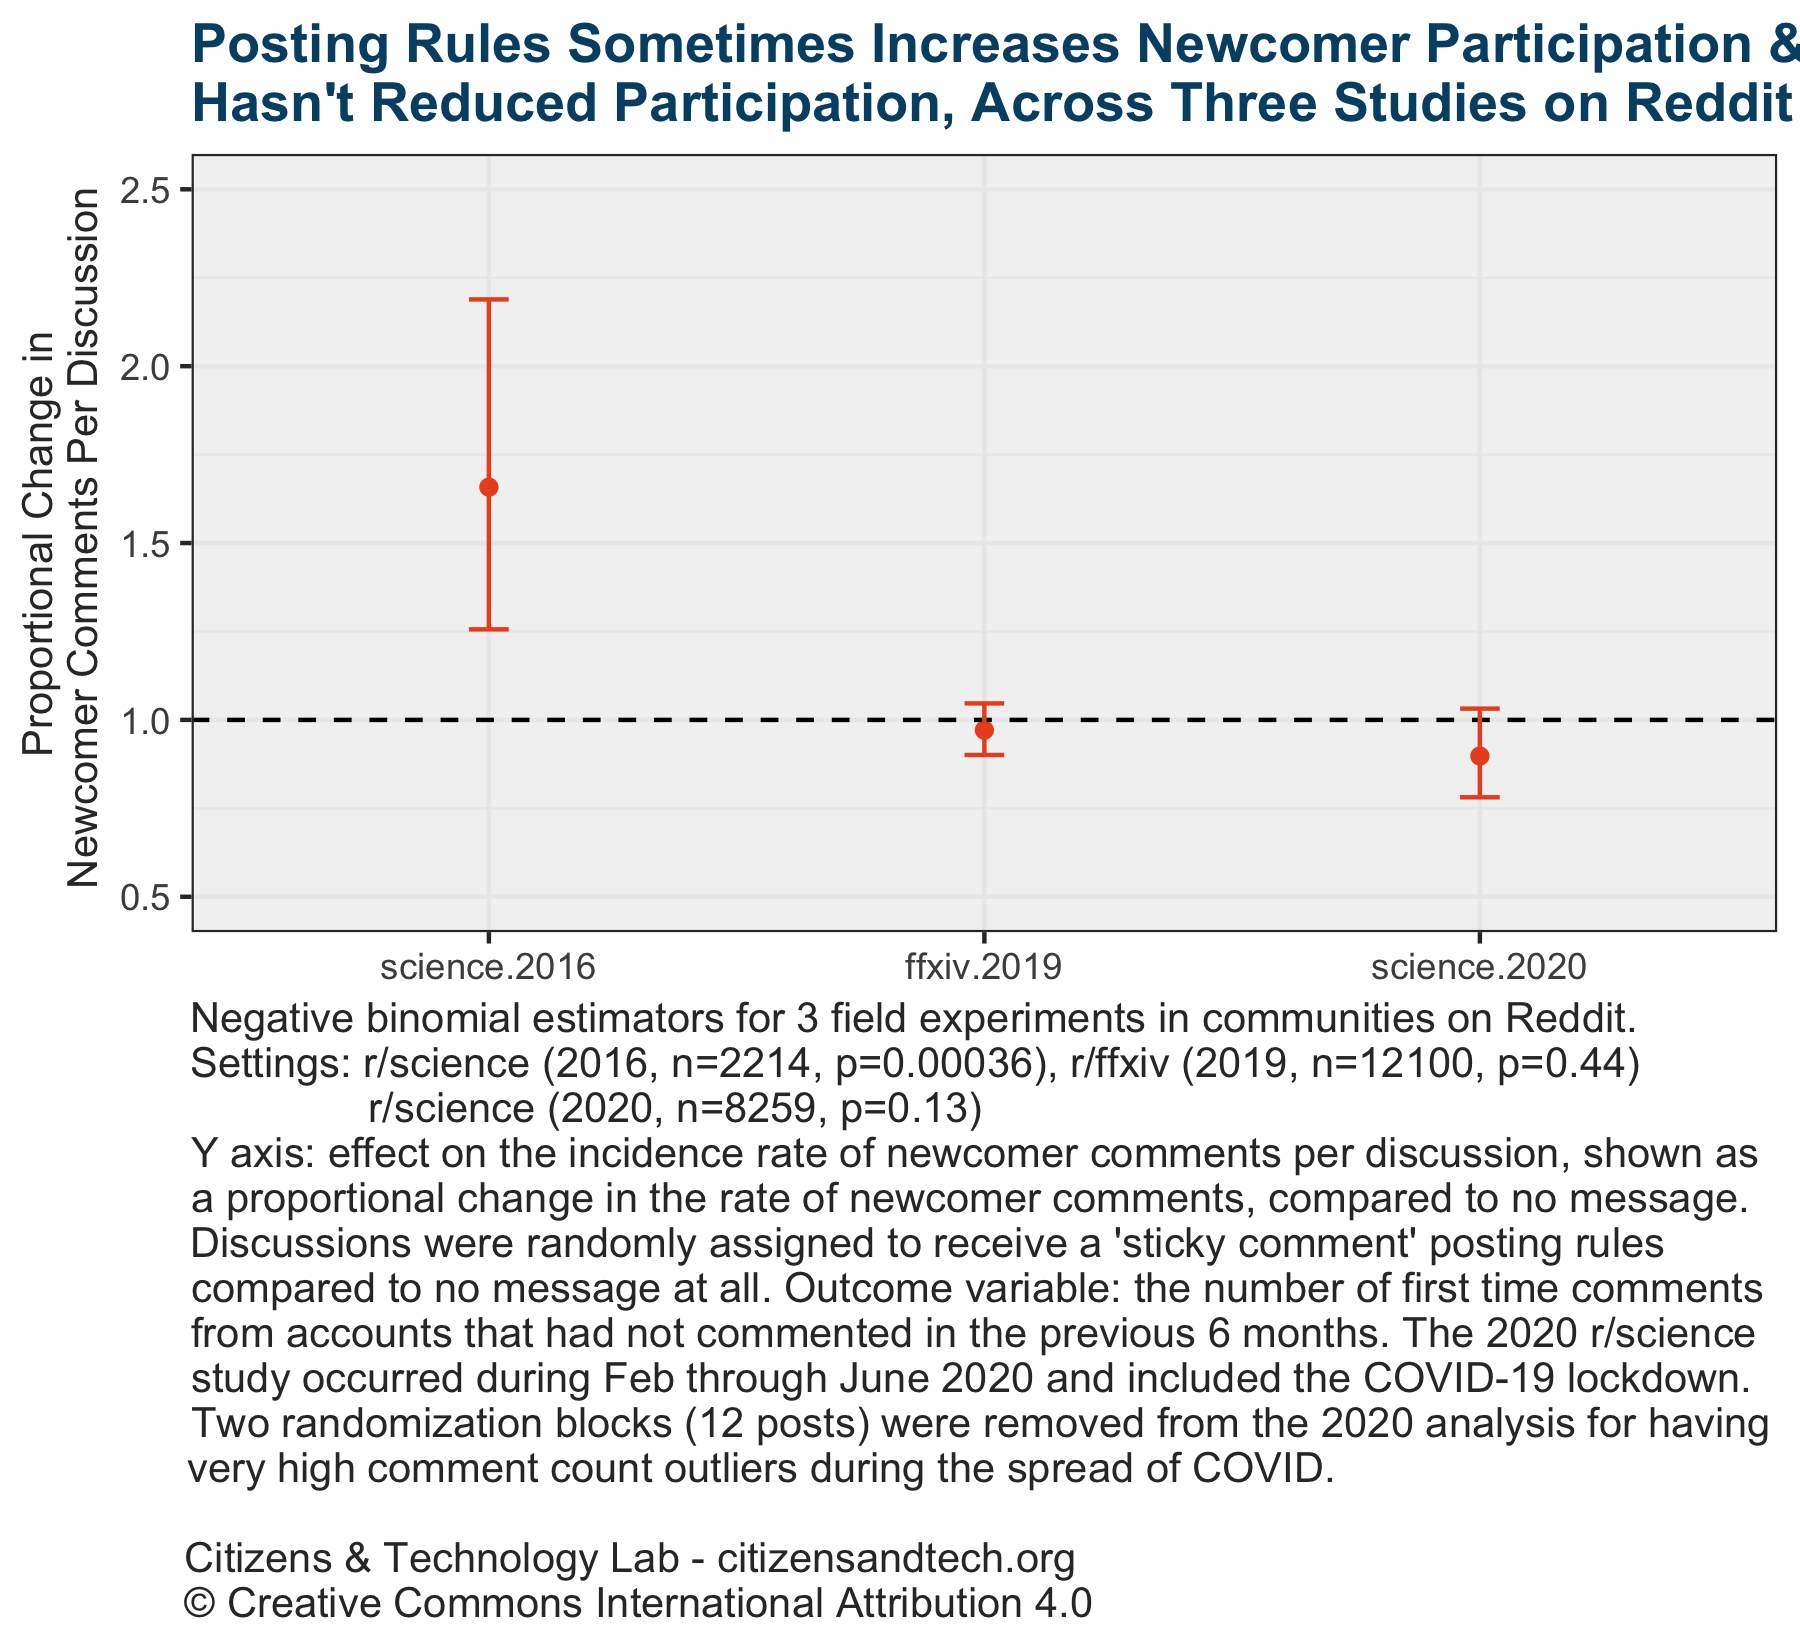

In [716]:
options(repr.plot.width = 6, repr.plot.height = 5.5)

x.just = 1
h.just = 1


h3.plot <- 
    ggplot(h3.plot.df, aes(model.name, treat.estimate.irr)) +
        geom_point(color=chartpalette[1]) +
        geom_hline(yintercept=1, linetype="dashed") +
        geom_errorbar(ymin=h3.plot.df$treat.estimate.irr.lwr, 
                      ymax=h3.plot.df$treat.estimate.irr.upr,
                      width=0.08, color=chartpalette[1]) +
        ylim(0.5, 2.5) +
        cat.theme +
        theme(legend.position = "none") +
        ylab("Proportional Change in\n Newcomer Comments Per Discussion") +
        ggtitle(paste("Posting Rules Sometimes Increases Newcomer Participation &\n",
                      # nrow(meta.analysis.df)
                      "Hasn't Reduced Participation, Across Three Studies on Reddit", sep="")) +
        xlab(paste("Negative binomial estimators for 3 field experiments in communities on Reddit.\n",
                   "Settings: r/science (2016, n=",nrow(subset(meta.analysis.df, study=="science.2017")),
                   ", p=",prettyNum(subset(h3.plot.df, model.name=="science.2016")$treat.estimate.pvalue, digits=2), 
                   "), r/ffxiv (2019, n=", nrow(subset(meta.analysis.df, study=="ffxiv.2019")),
                   ", p=",prettyNum(subset(h3.plot.df, model.name=="ffxiv.2019")$treat.estimate.pvalue, digits=2), 
                   ")\n                r/science (2020, n=", nrow(subset(meta.analysis.df, study=="science.2020")), 
                   ", p=",prettyNum(subset(h3.plot.df, model.name=="science.2020")$treat.estimate.pvalue, digits=2),                    
                   ")\n", 
                   "Y axis: effect on the incidence rate of newcomer comments per discussion, shown as\n",
                   "a proportional change in the rate of newcomer comments, compared to no message.\n",
                   "Discussions were randomly assigned to receive a 'sticky comment' posting rules\n", 
                   "compared to no message at all. Outcome variable: the number of first time comments\n",
                   "from accounts that had not commented in the previous 6 months. The 2020 r/science\n",
                   "study occurred during Feb through June 2020 and included the COVID-19 lockdown.\n",
                   "Two randomization blocks (12 posts) were removed from the 2020 analysis for having\n",
                   "very high comment count outliers during the spread of COVID.",
                   end.caption.text,
                   sep=""))
h3.plot

#annotate_figure(h3.plot,
#         annotation_custom(grob=logo.pngob, xmin=-1, xmax=2, ymin=-1, ymax=2))#, ymin=-0.90, xmin=0.7-(0.7*h.just), xmax=1-(0.7*h.just)))

### Total Comments Removed (not pre-registered, but included in case communities are interested)

In [717]:
h4.science.2017.m <- glm.nb(num.comments.removed ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="science.2017") )

h4.science.2020.m <- glm.nb(num.comments.removed ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="science.2020") )
h4.ffxiv.2019.m   <- glm.nb(num.comments.removed ~ 
                                treatment + 
                                visible,
                                data=subset(meta.analysis.df, study=="ffxiv.2019") )

print(screenreg(list(h4.science.2017.m, h4.ffxiv.2019.m, h4.science.2020.m)))



h4.plot.df <- rbind(
    generate.result.table(h4.science.2017.m, "science.2017", "treatment", nrow(exp.posts.science.2017.df)),
    generate.result.table(h4.ffxiv.2019.m,   "ffxiv.2019",   "treatment", nrow(exp.posts.ffxiv.df)),
    generate.result.table(h4.science.2020.m, "science.2020", "treatment", nrow(exp.posts.science.2020.df))
)



                Model 1       Model 2       Model 3      
---------------------------------------------------------
(Intercept)         1.79 ***     -1.65 ***       2.70 ***
                   (0.13)        (0.14)         (0.07)   
treatment           0.38 **       0.07          -0.29 ***
                   (0.14)        (0.08)         (0.07)   
visibleTrue         0.65 ***     -0.04           0.76 ***
                   (0.15)        (0.14)         (0.07)   
---------------------------------------------------------
AIC              8040.26      10107.04       37985.92    
BIC              8063.07      10136.64       38013.99    
Log Likelihood  -4016.13      -5049.52      -18988.96    
Deviance         1574.80       2987.47        6789.50    
Num. obs.        2214         12100           8259       
*** p < 0.001, ** p < 0.01, * p < 0.05


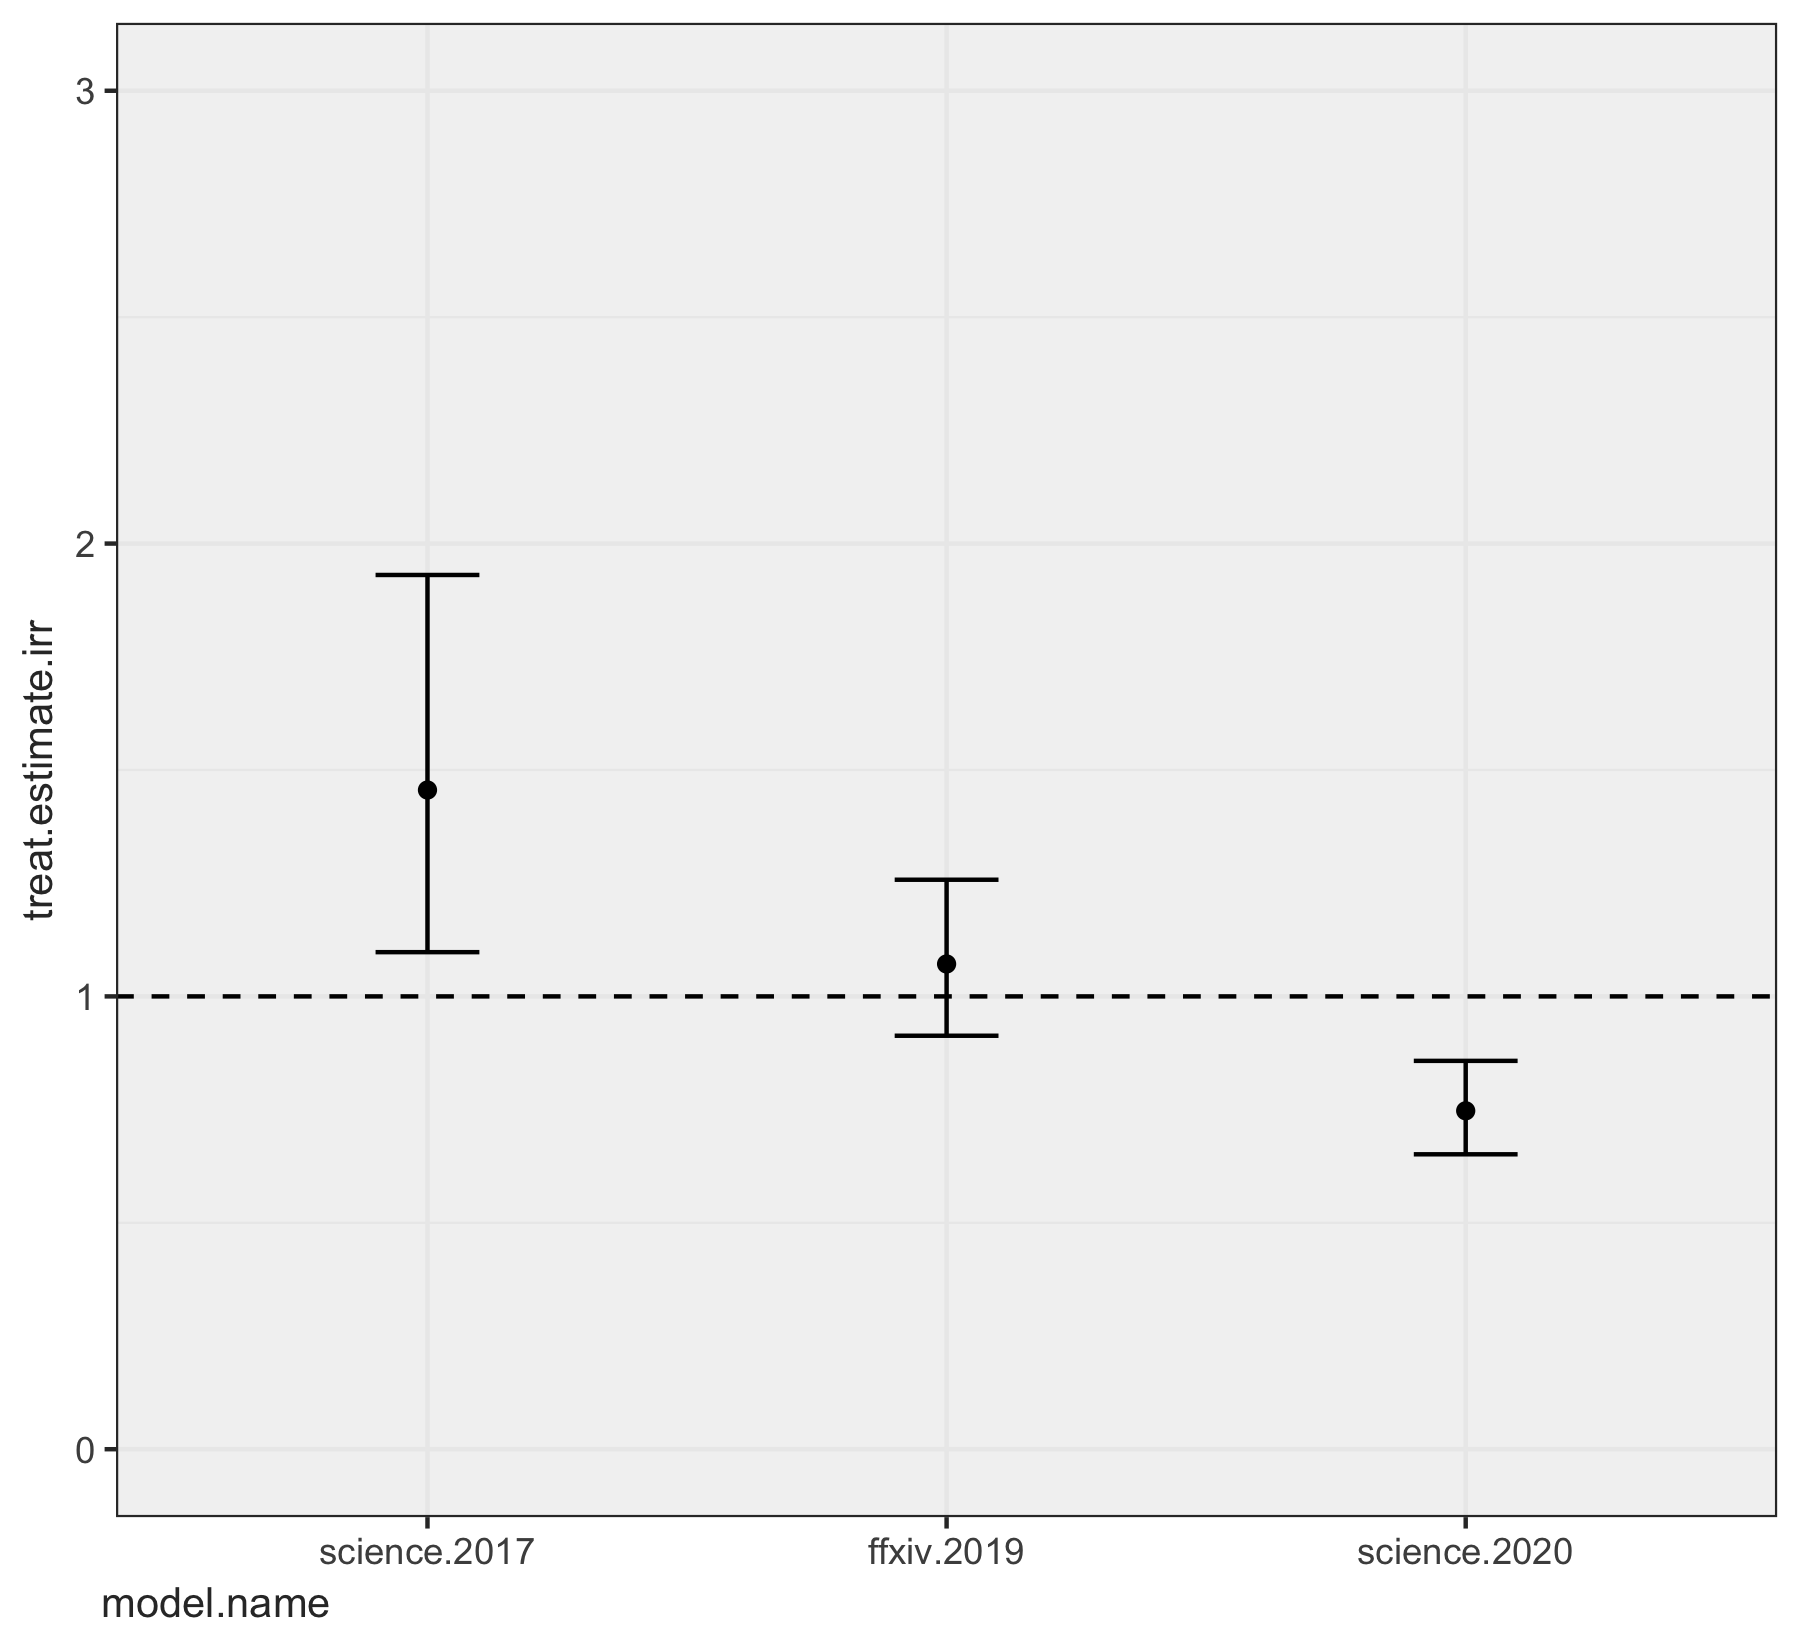

In [718]:
ggplot(h4.plot.df, aes(model.name, treat.estimate.irr)) +
    geom_point() +
    geom_hline(yintercept=1, linetype="dashed") +
    geom_errorbar(ymin=h4.plot.df$treat.estimate.irr.lwr, 
                  ymax=h4.plot.df$treat.estimate.irr.upr,
                  width=0.2) +
    ylim(0, 3) +
    cat.theme